# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/101rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/102rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/103rep_25noiseLevel_MM_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/101rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/102rep_25noiseLevel_MM_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/103rep_25noiseLevel_MM_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.320301        0.203141  0.051135  0.303779  0.020326   
       0.25   0.312452        0.197530  0.049836  0.281811  0.032413   
       0.50   0.315318        0.208724  0.046464  0.251640  0.059118   
       0.75   0.320863        0.200910  0.046494  0.221196  0.083048   
       1.00   0.309800        0.198753  0.044168  0.191634  0.106898   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198403  0.009788  0.040606  0.047477  0.000000  
       0.25  0.202464  0.007127  0.042024  0.056603  0.000310  
       0.50  0.196915  0.006133  0.038858  0.059653  0.001081  
       0.75  0.198298  0.006647  0.038032  0.065524  0.002341  
       1.00  0.200367  0.007585  0.033709  0.077227  0.003680

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.312511        0.204629  0.051322  0.293097  0.020650   
       0.25   0.315877        0.200360  0.049001  0.279295  0.032724   
       0.50   0.324278        0.203214  0.047617  0.255086  0.060629   
       0.75   0.313521        0.200833  0.048253  0.244770  0.083824   
       1.00   0.327000        0.190012  0.046372  0.188892  0.108272   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201656  0.009873  0.039097  0.049837  0.000000  
       0.25  0.202896  0.006790  0.040179  0.052524  0.000305  
       0.50  0.195804  0.005726  0.039077  0.059538  0.001080  
       0.75  0.194924  0.006355  0.037616  0.065793  0.002191  
       1.00  0.204681  0.007784  0.033072  0.071331  0.003847

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.290630        0.198698  0.050480  0.297109  0.019457   
       0.25   0.312826        0.199856  0.050816  0.298715  0.032191   
       0.50   0.322991        0.191443  0.049280  0.268974  0.059027   
       0.75   0.306444        0.200758  0.045964  0.215057  0.086777   
       1.00   0.322976        0.206172  0.046658  0.193034  0.102076   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211636  0.010108  0.040432  0.048775  0.000000  
       0.25  0.190939  0.007280  0.040004  0.054045  0.000315  
       0.50  0.191027  0.005963  0.038893  0.057594  0.001075  
       0.75  0.192239  0.006594  0.036349  0.064727  0.002239  
       1.00  0.201662  0.007638  0.034593  0.072588  0.003541

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25   0.307536        0.199929  0.053825  0.264342  0.052381   
         0.50   0.302969        0.201308  0.060000  0.195479  0.112762   
         0.75   0.283090        0.199303  0.069457  0.130116  0.154462   
         1.00   0.274914        0.194288  0.079106  0.079675  0.173881   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.203898  0.009923  0.040045  0.048697  0.000000  
         0.25  0.193532  0.011239  0.040850  0.055387  0.000135  
         0.50  0.181202  0.014024  0.038906  0.065404  0.000488  
         0.75  0.175223  0.017051  0.036721  0.081182  0.001087  
         1.00  0.174100  0.020915  0.032977  0.101425  0.001904

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.101863e+01  4.015845e+01      37.692821  5.723769e+01   
         0.25  4.486963e+06  2.379775e+06  215170.605512  1.421525e+06   
         0.50  5.600547e+06  3.542830e+06  348031.428814  2.226925e+06   
         0.75  5.898077e+06  4.193526e+06  418539.384158  2.716502e+06   
         1.00  5.950154e+06  4.740187e+06  475611.656791  3.135893e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.791488  5.554329e+01  5.504357e+01      18.708835   
         0.25  472440.652562  2.249389e+06  2.613968e+06  427129.834888   
         0.50  712984.410862  3.752934e+06  3.280235e+06  638585.081830   
         0.75  886163.874252  4.752821e+06  3.593999e+06  761165.327324   
         1.00  991658.939558  5.524615e+06  3.766037e+06  847123.904465   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.550140  
         0.25     186883.918585  
         0.50     278775.287738  
         0.75     351041.917068  
         1.00     403961.615942

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,,Missing Values,% of Total Values


,,Missing Values,% of Total Values


# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


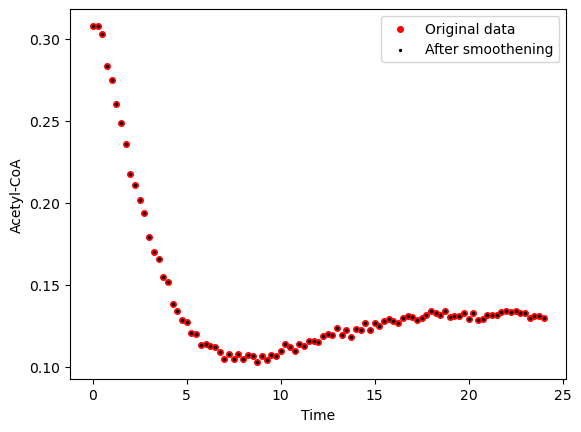

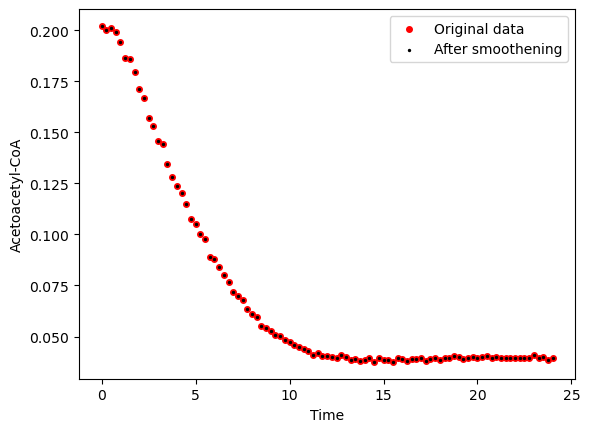

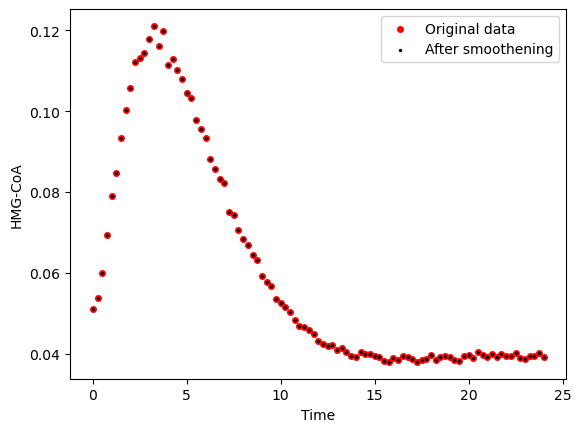

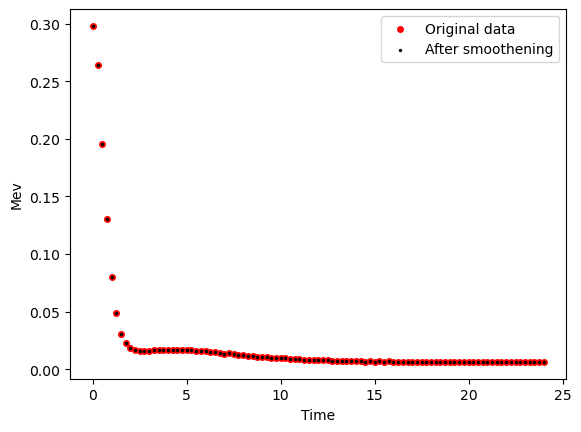

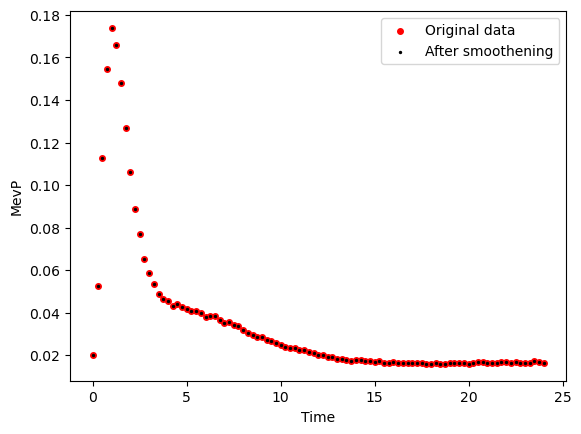

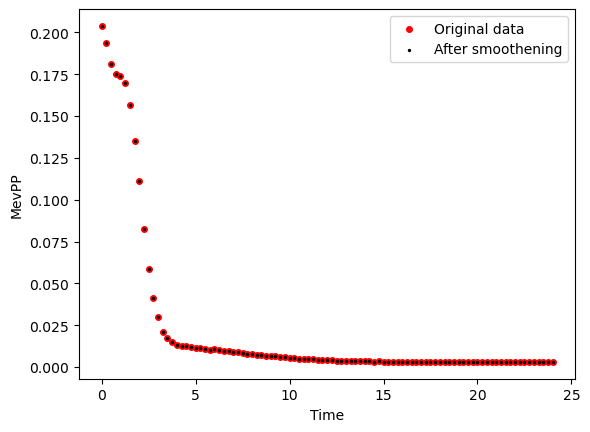

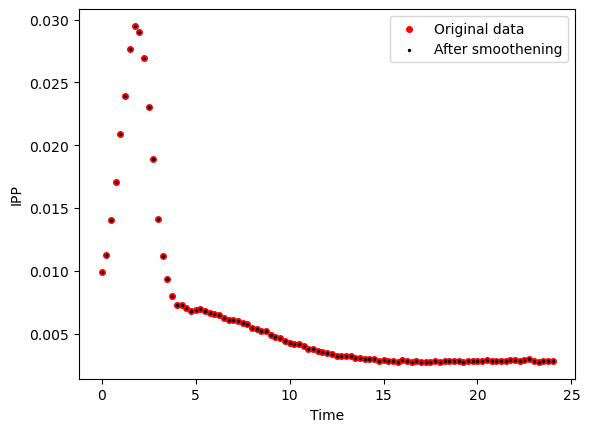

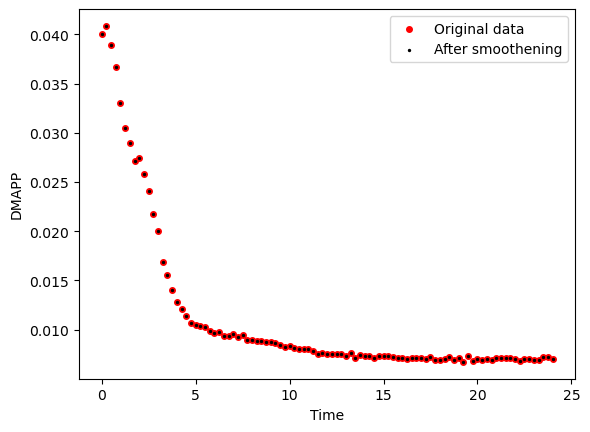

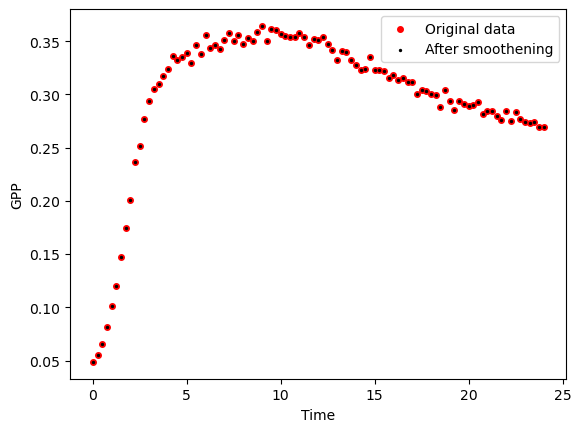

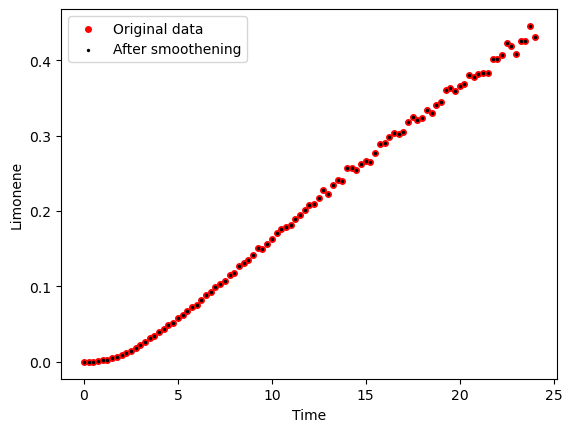

Strain Strain 2


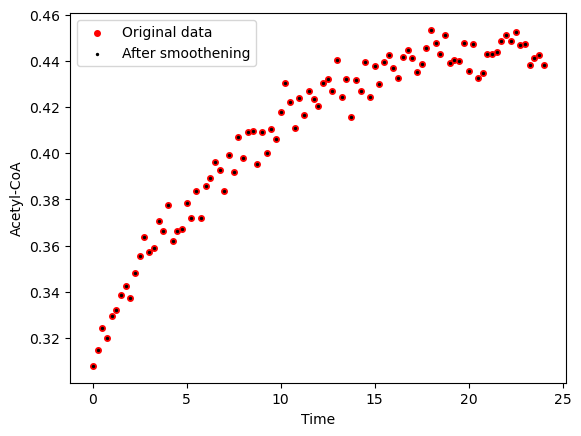

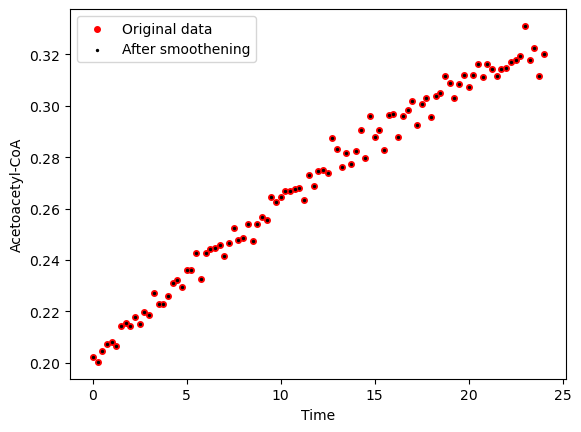

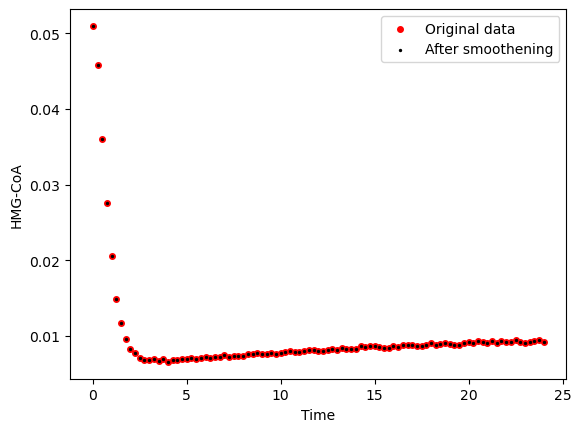

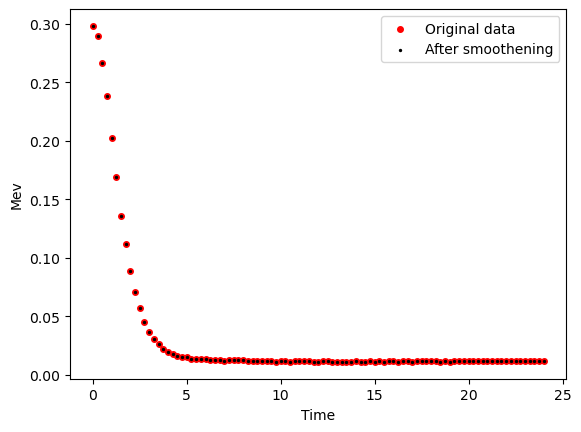

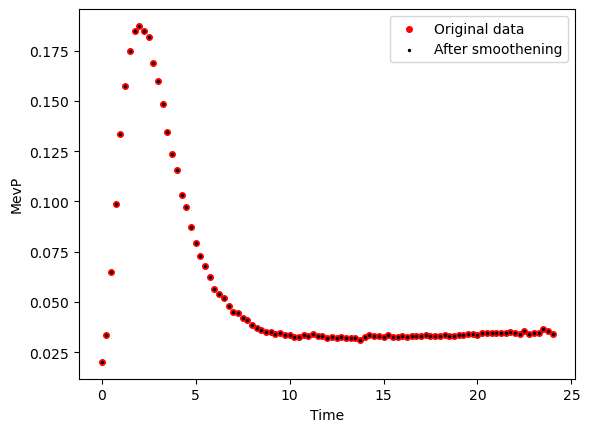

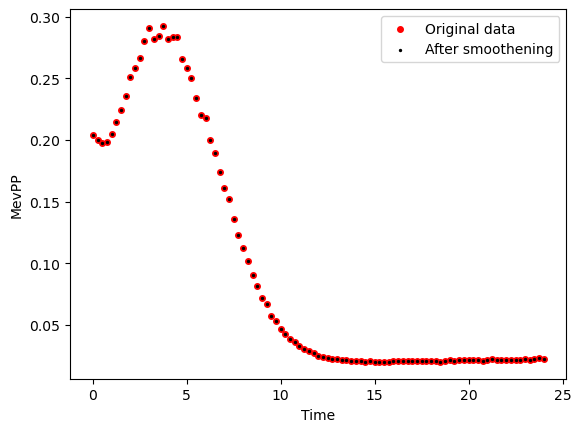

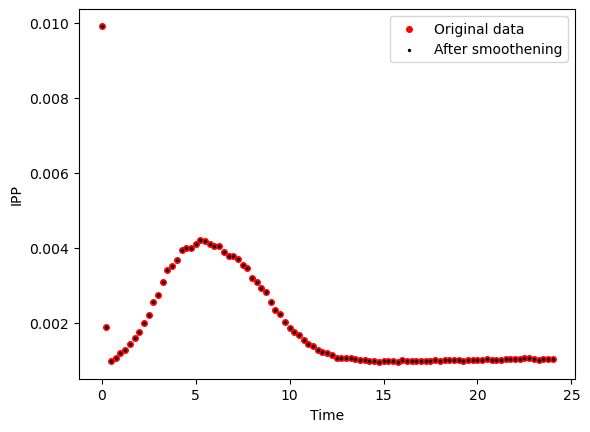

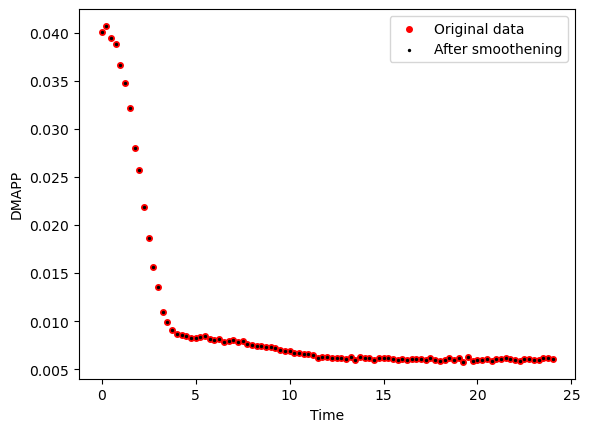

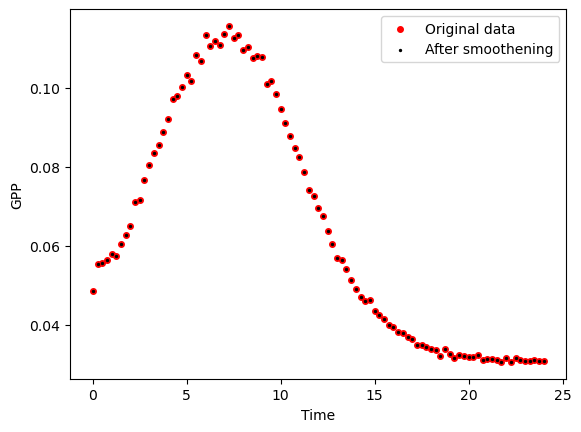

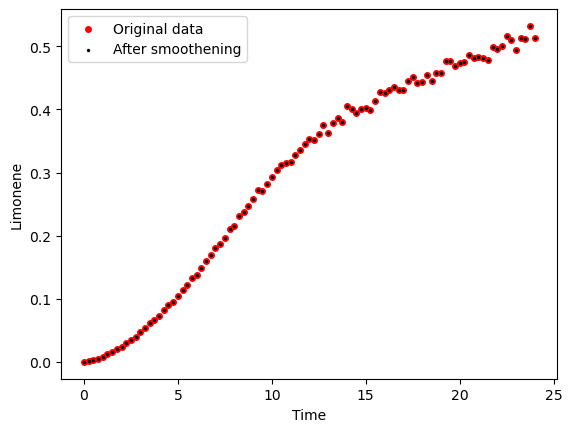

Strain Strain 3


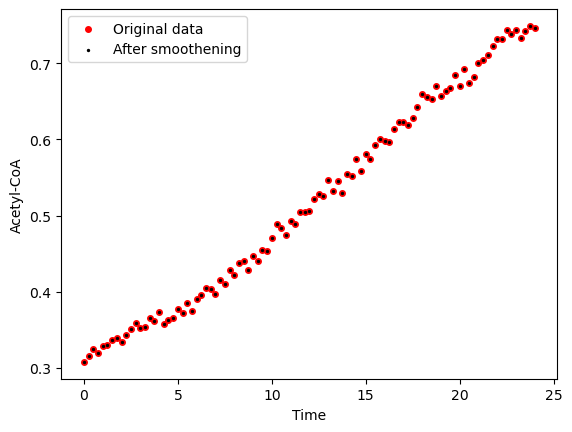

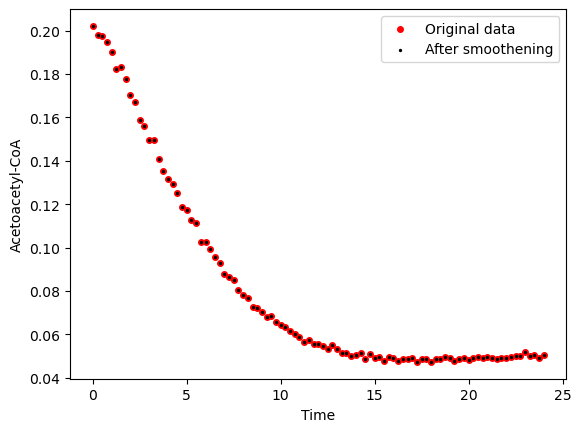

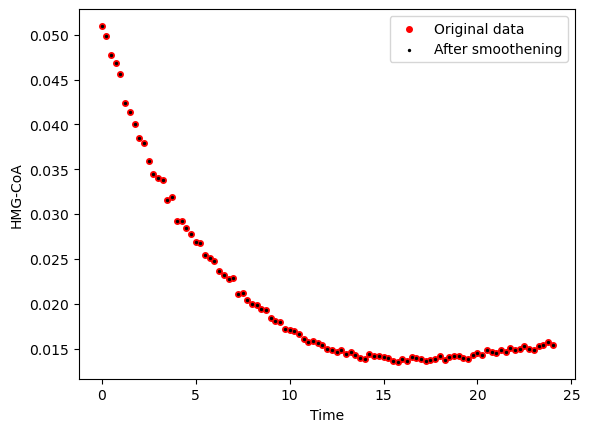

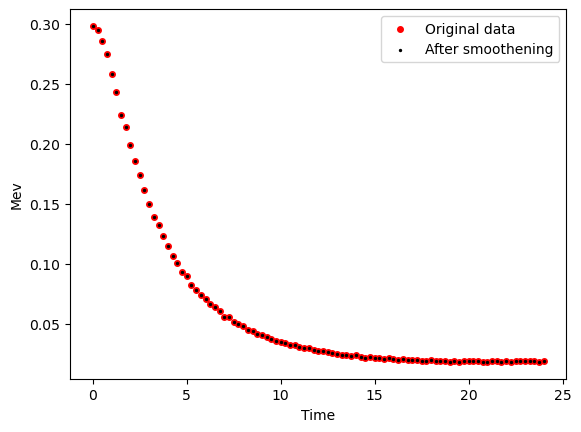

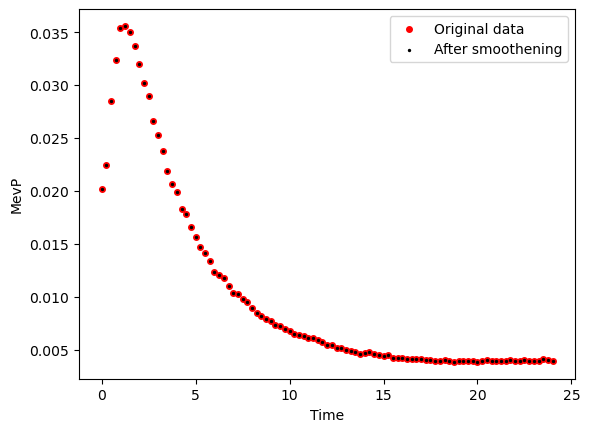

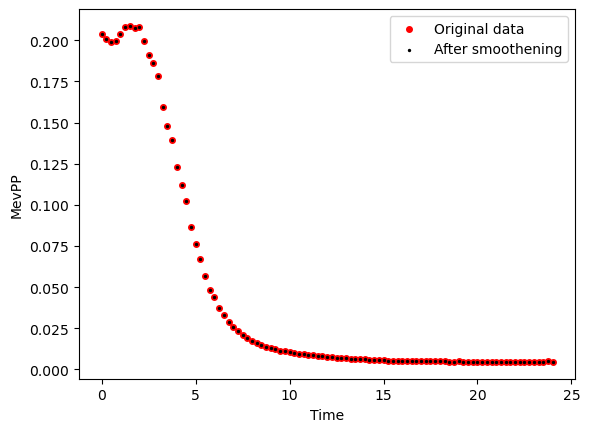

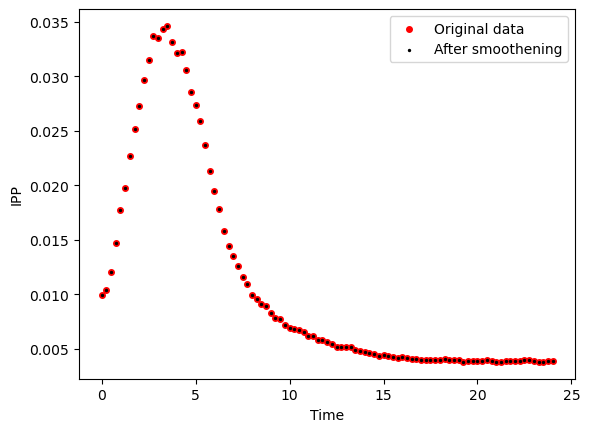

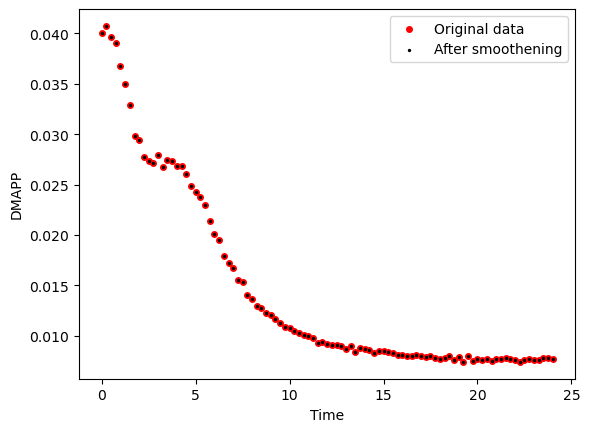

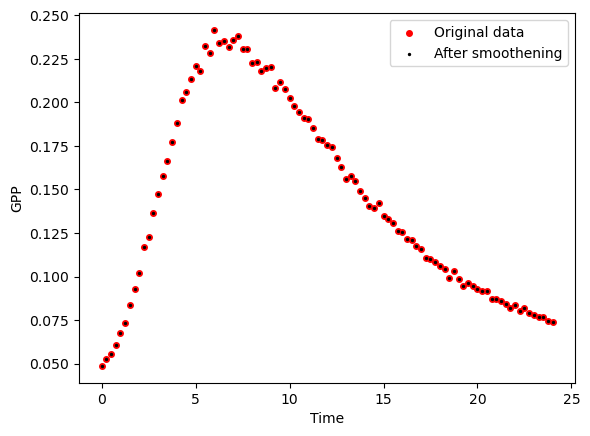

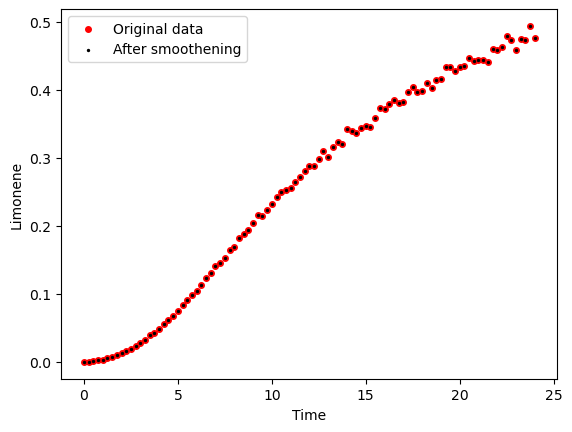

Strain WT


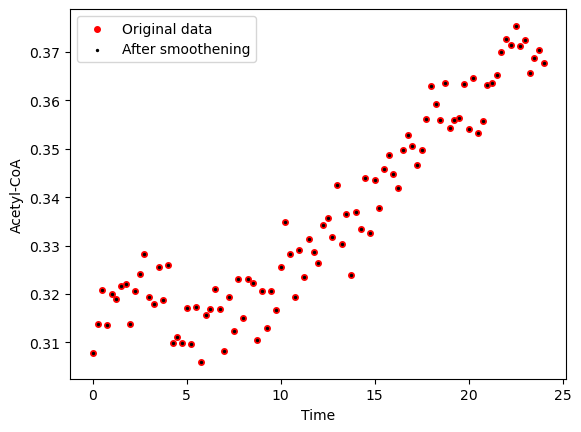

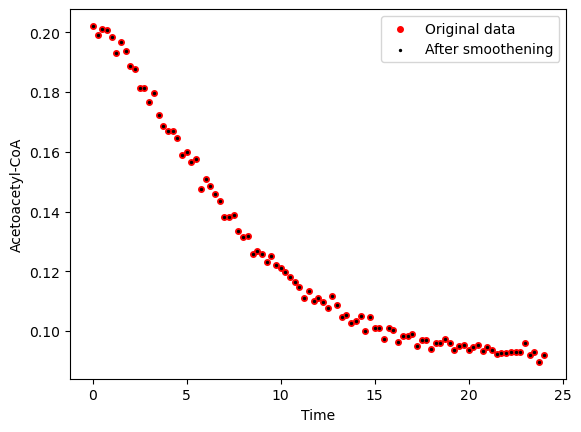

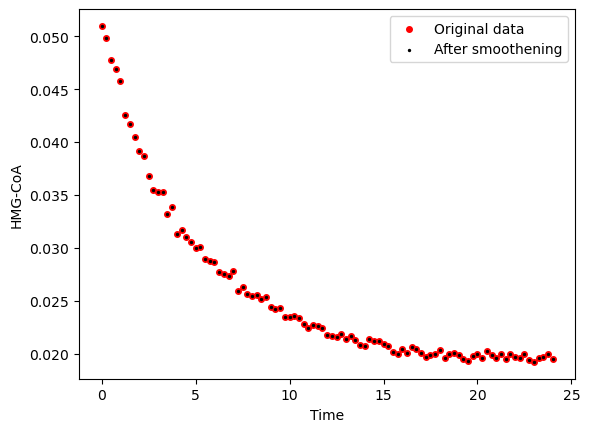

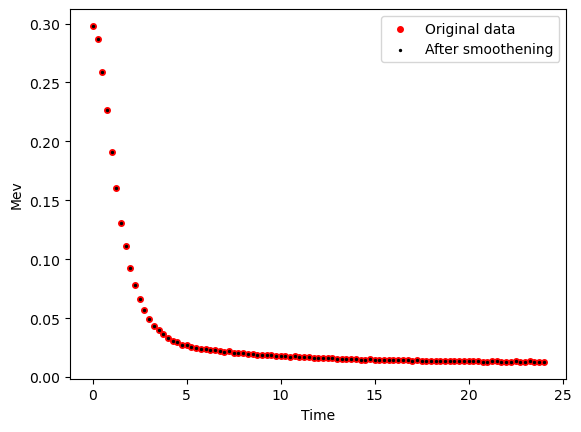

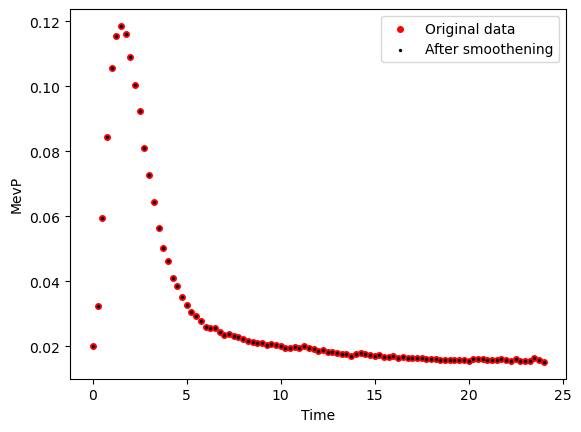

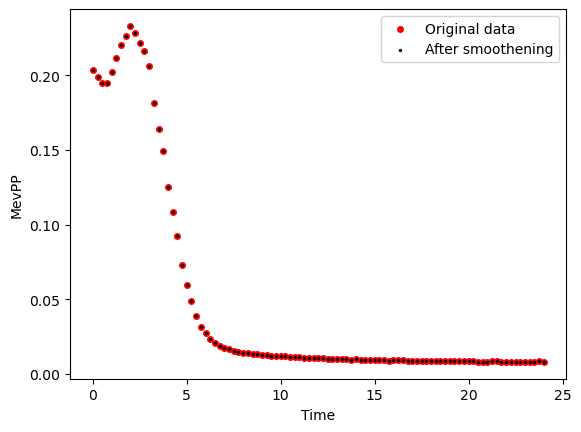

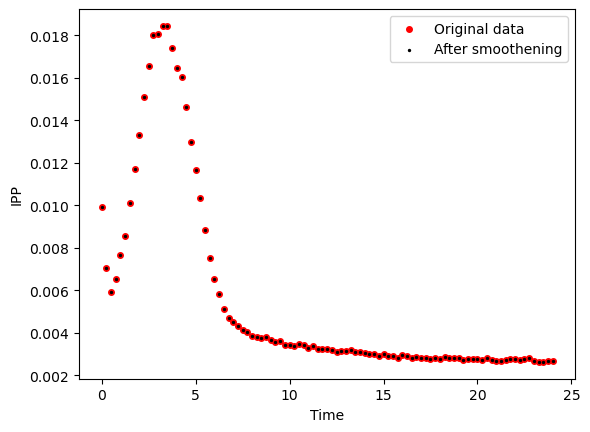

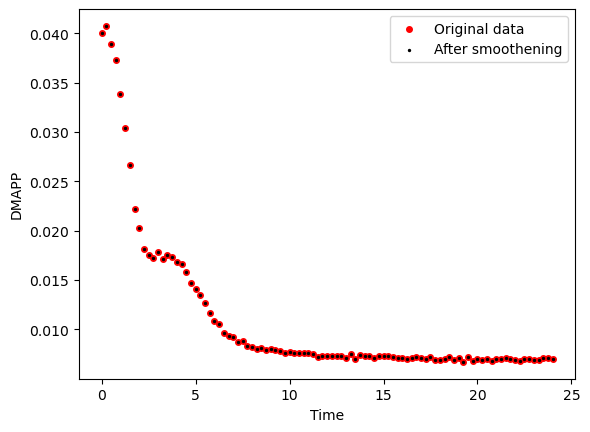

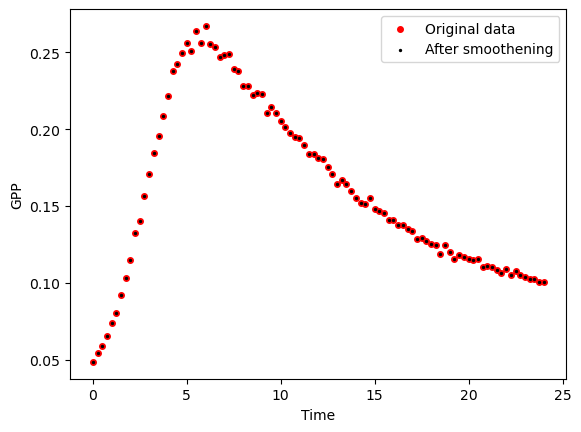

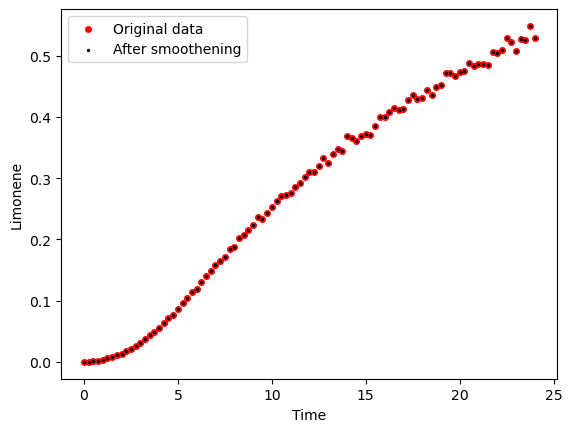

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


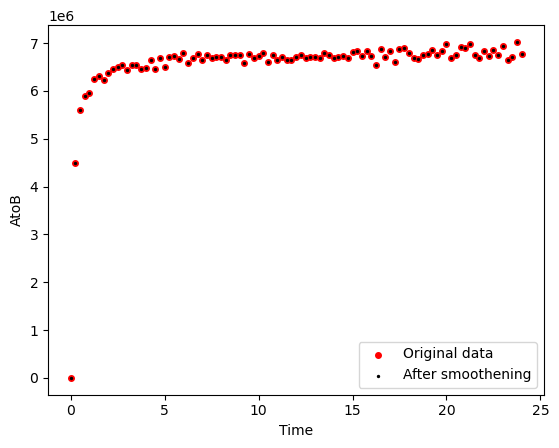

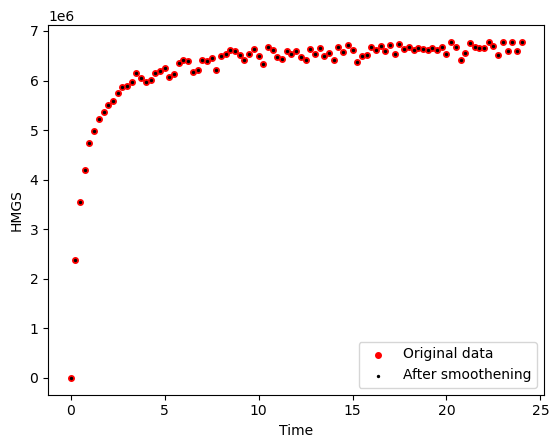

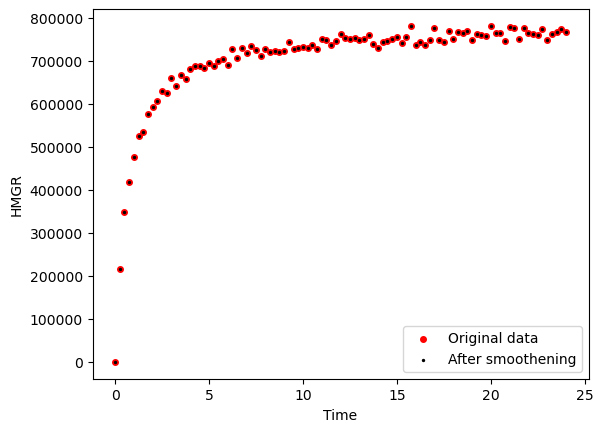

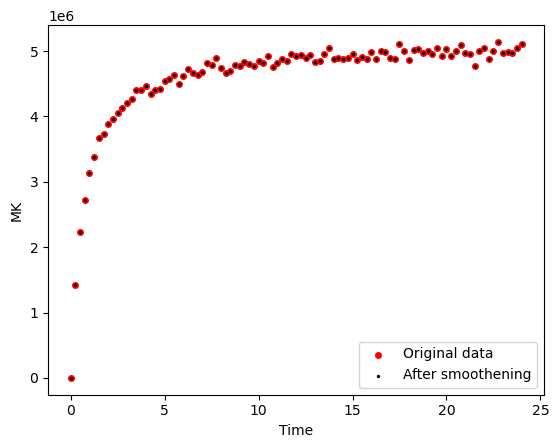

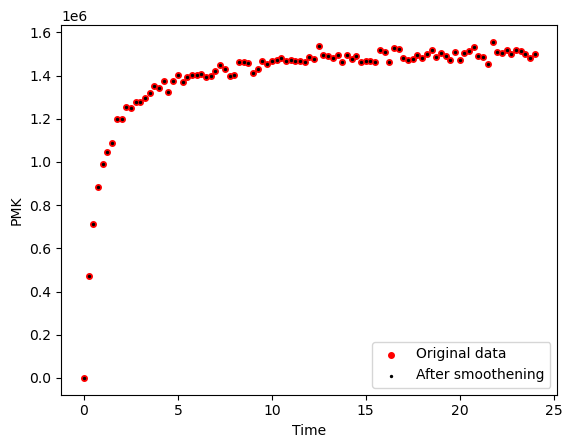

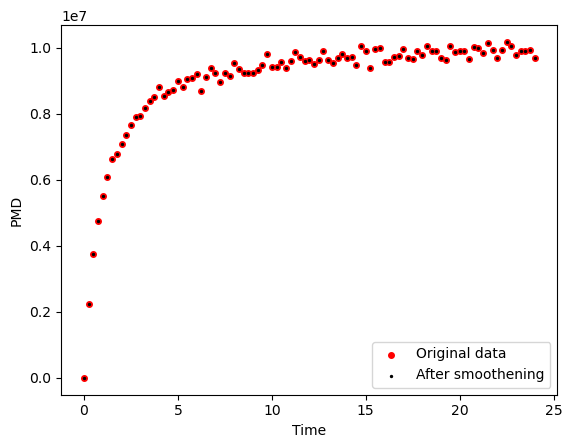

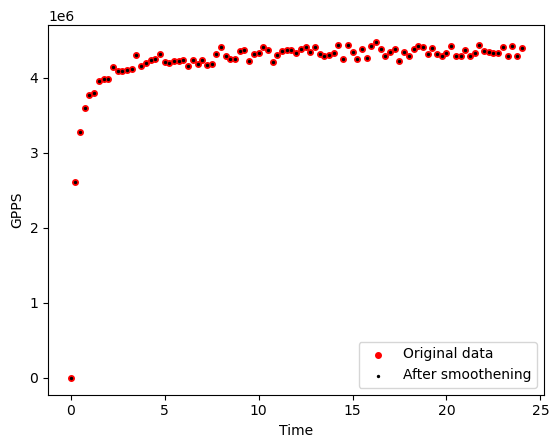

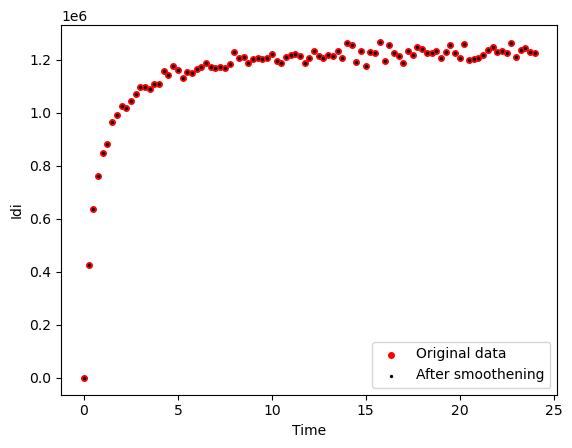

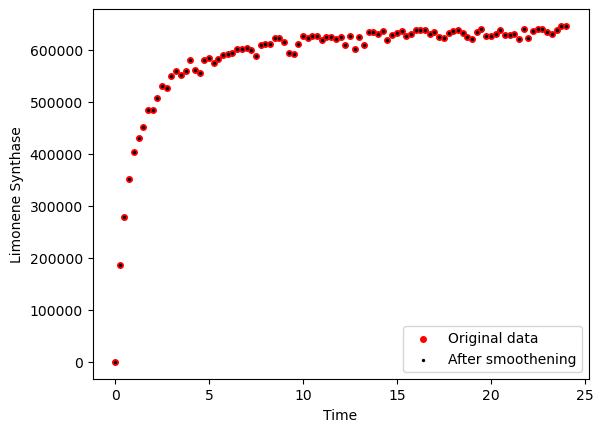

Strain Strain 2


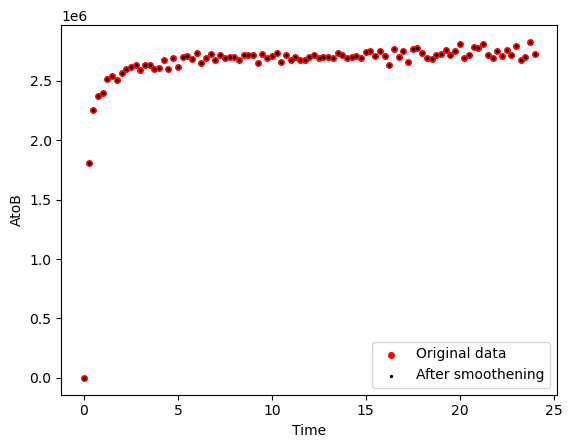

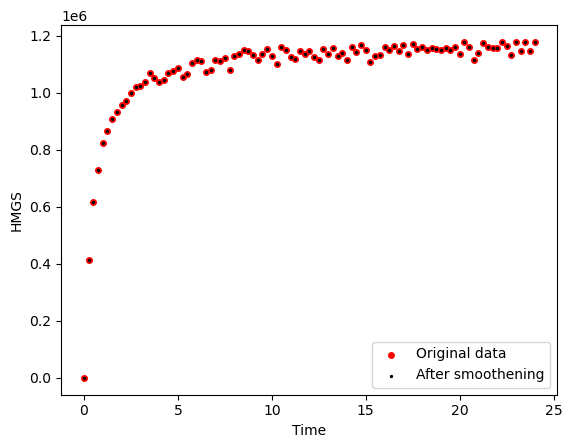

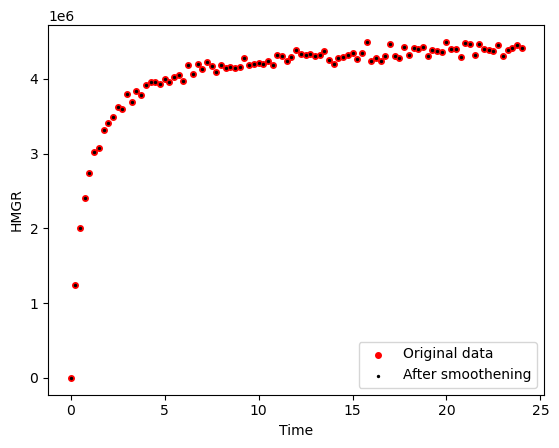

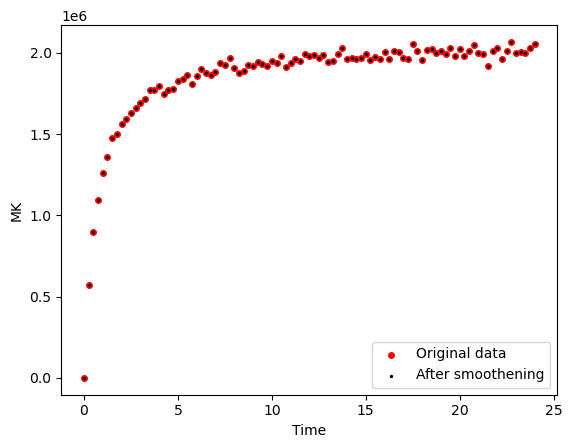

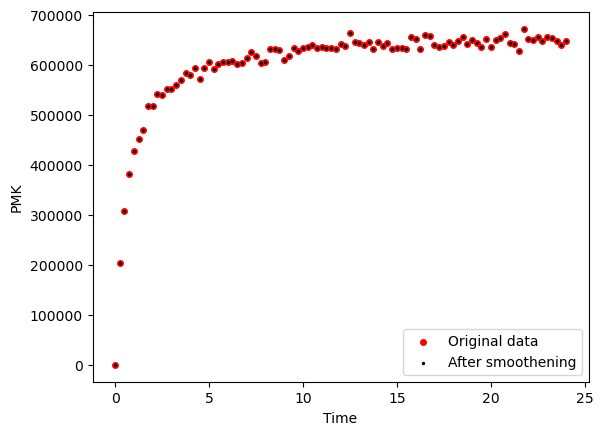

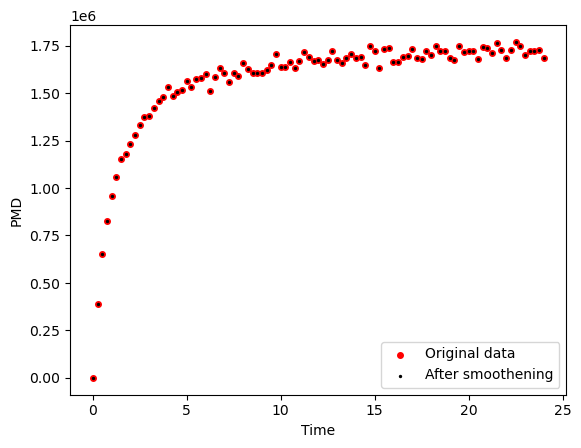

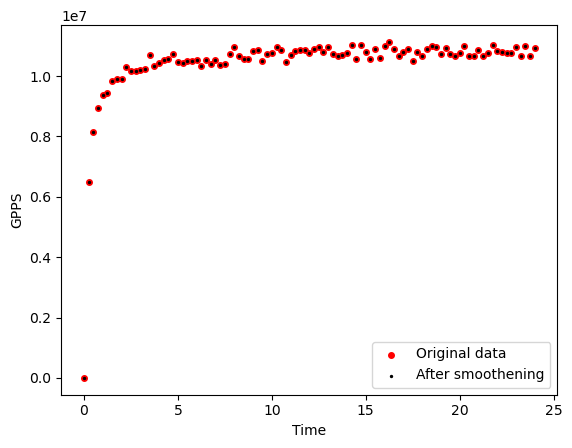

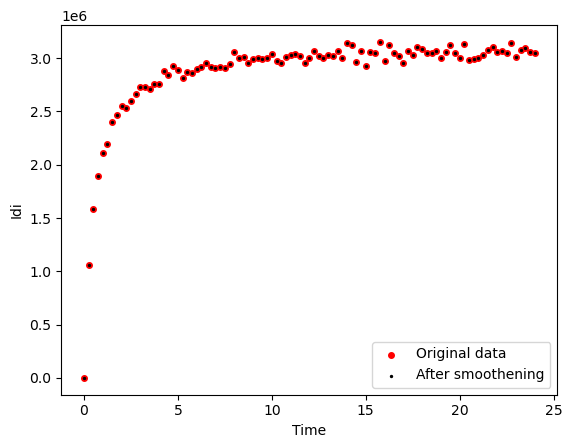

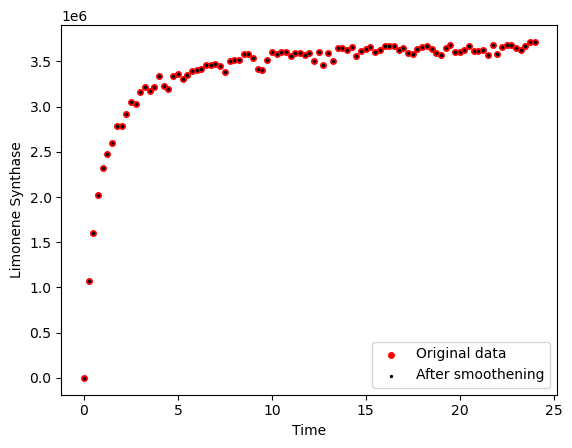

Strain Strain 3


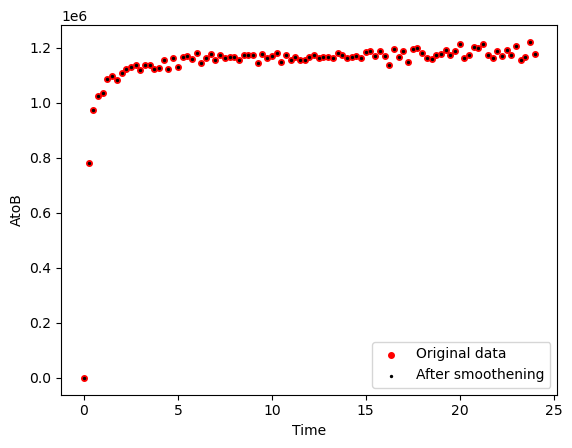

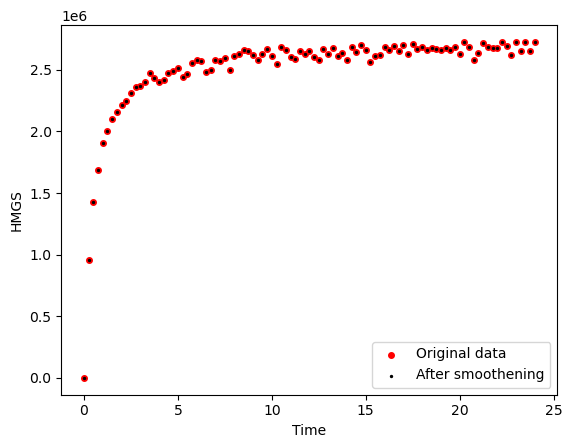

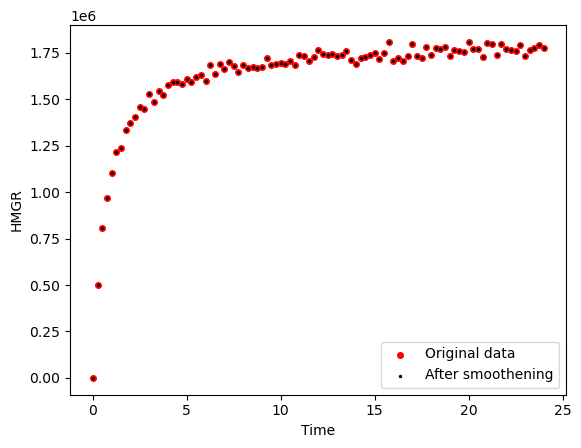

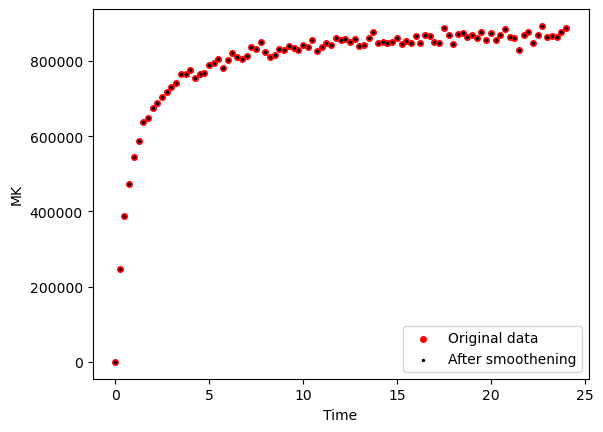

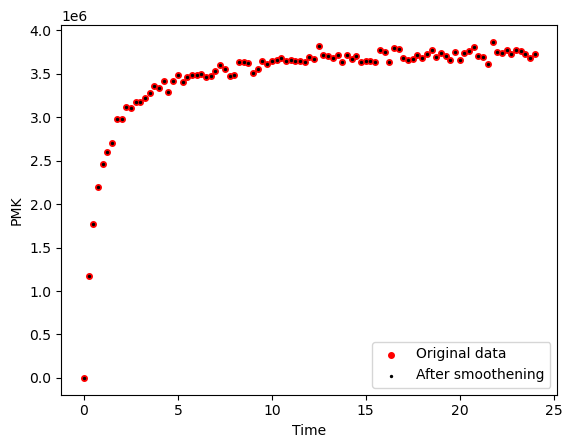

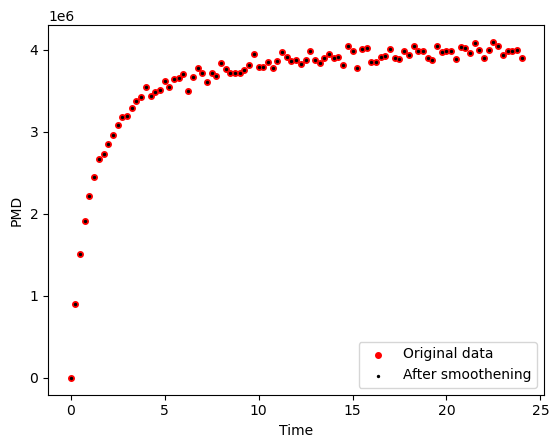

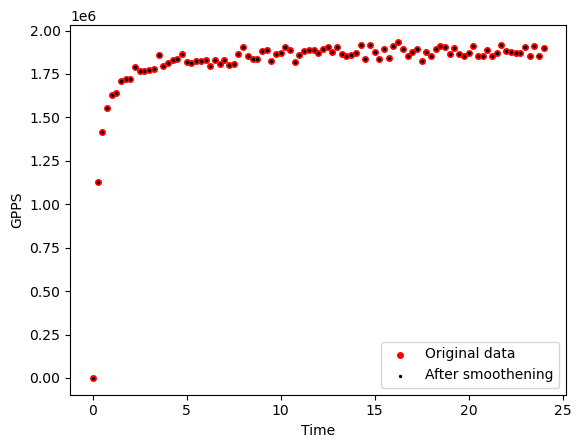

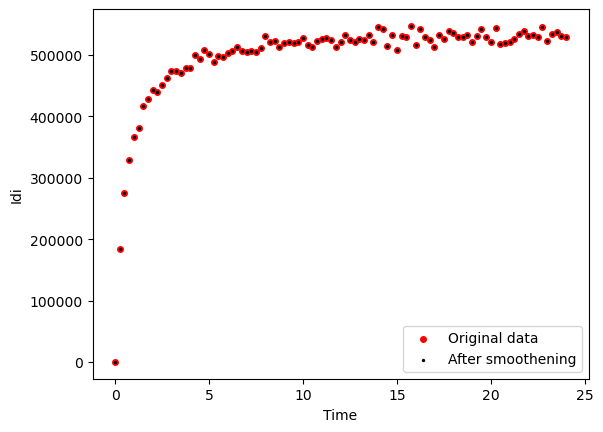

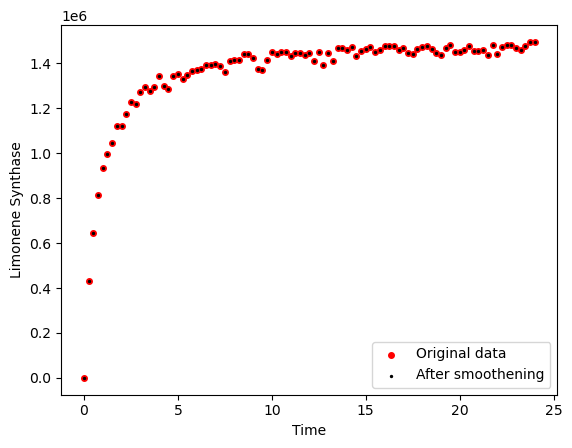

Strain WT


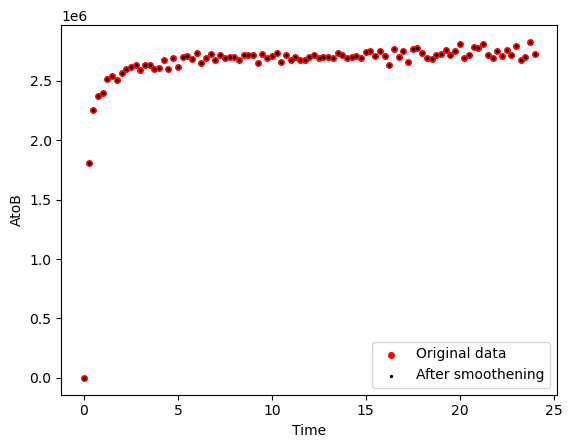

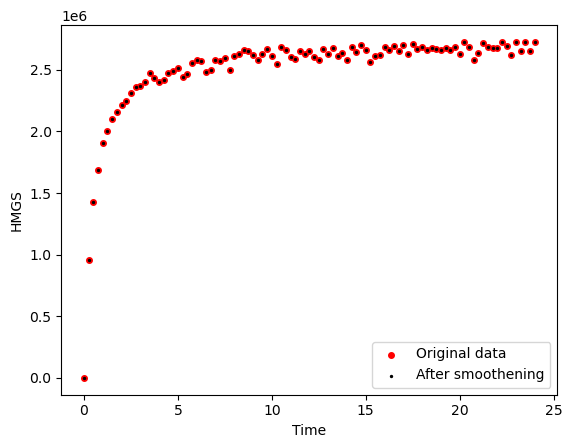

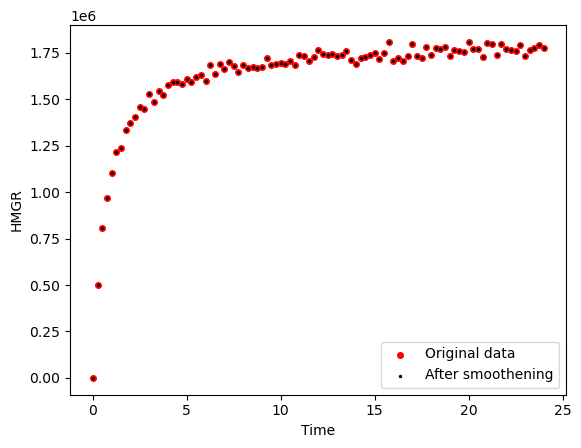

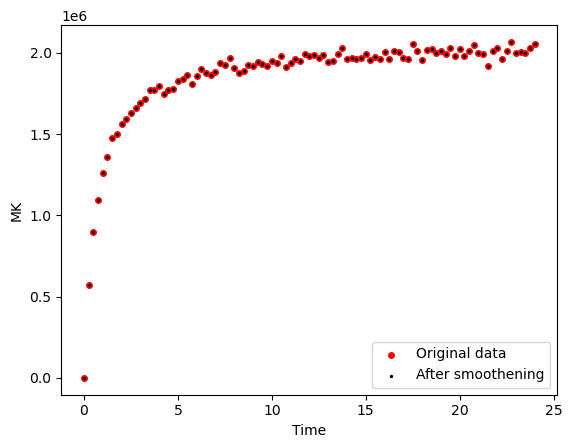

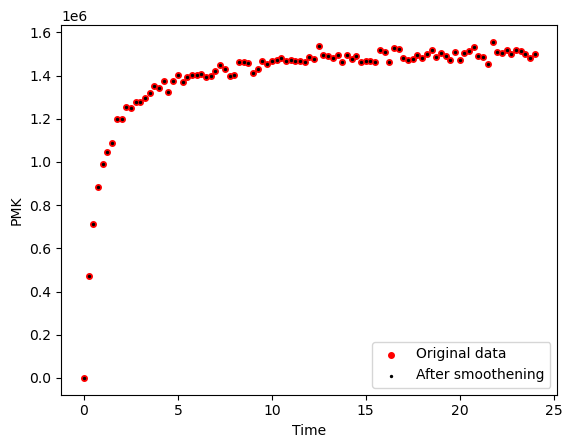

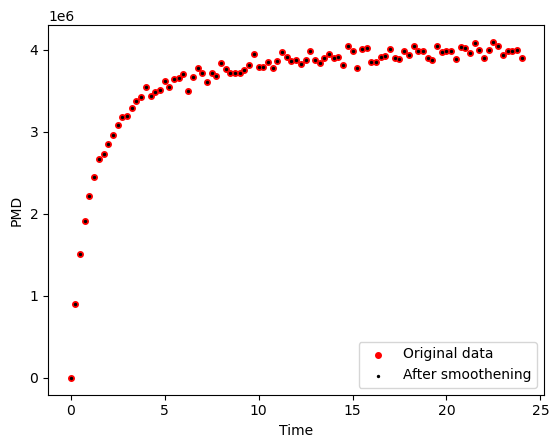

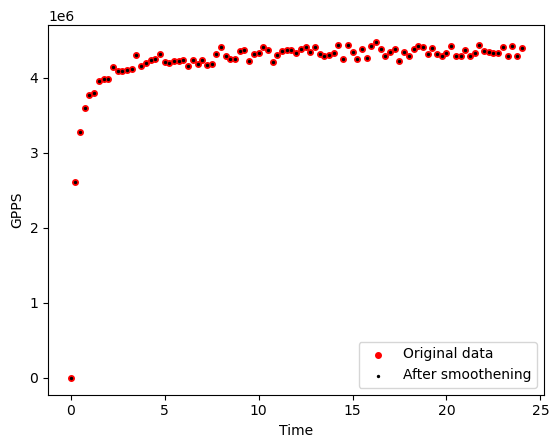

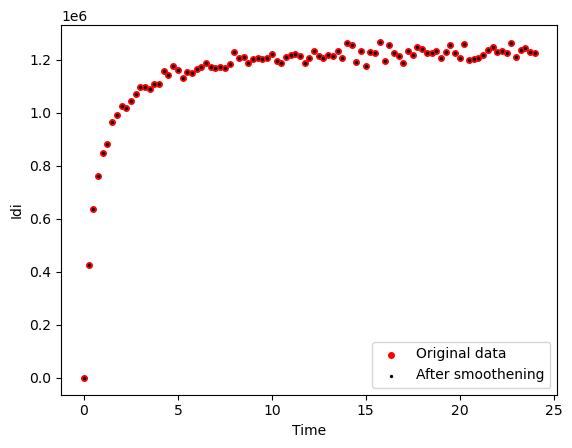

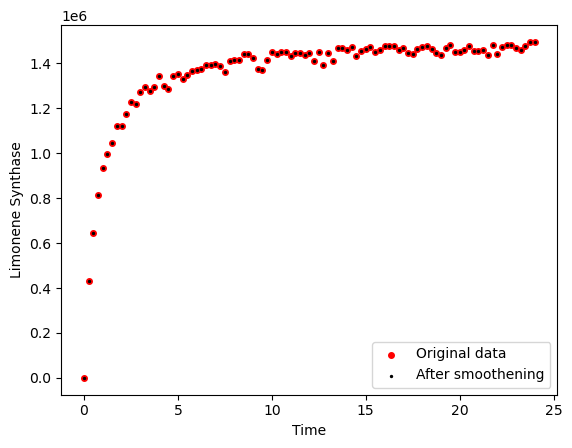

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25    0.307536        0.199929  0.053825  0.264342  0.052381   
         0.50    0.302969        0.201308  0.060000  0.195479  0.112762   
         0.75    0.283090        0.199303  0.069457  0.130116  0.154462   
         1.00    0.274914        0.194288  0.079106  0.079675  0.173881   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.372369        0.096121  0.019218  0.013121  0.015609   
         23.25   0.365523        0.092006  0.019604  0.013424  0.015420   
         23.50   0.368637        0.093034  0.019644  0.013161  0.016253   
         23.75   0.370468        0.089665  0.019993  0.012871  0.015928   
         24.00   0.367688        0.091909  0.019458  0.013079  0.015188   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.203898  0.009923  0.040045  0.048697  0.000000  ...   
         0.25   0.193532  0.011239  0.040850  0.055387  0.000135  ...   
         0.50   0.181202  0.014024  0.038906  0.065404  0.000488  ...   
         0.75   0.175223  0.017051  0.036721  0.081182  0.001087  ...   
         1.00   0.174100  0.020915  0.032977  0.101425  0.001904  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.008199  0.002668  0.006879  0.103587  0.507507  ...   
         23.25  0.008012  0.002632  0.006877  0.102811  0.526643  ...   
         23.50  0.008165  0.002645  0.007107  0.102832  0.525672  ...   
         23.75  0.008320  0.002683  0.007098  0.100524  0.548488  ...   
         24.00  0.008002  0.002676  0.006954  0.100340  0.529240  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.000545        0.003694  0.009453 -0.193974  0.214470   
         0.25    -0.018322       -0.001425  0.019104 -0.211160  0.189146   
         0.50    -0.036099       -0.006545  0.028754 -0.228347  0.163822   
         0.75    -0.049114       -0.013704  0.032271 -0.218864  0.115252   
         1.00    -0.052495       -0.017341  0.032788 -0.164455  0.032889   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.007619       -0.000238 -0.000221 -0.000111  0.000140   
         23.25   -0.002051       -0.003888  0.000621 -0.000174  0.000692   
         23.50   -0.001768       -0.004306  0.000347 -0.000255 -0.000134   
         23.75    0.002146        0.000449 -0.000530 -0.000379 -0.001425   
         24.00    0.006060        0.005205 -0.001408 -0.000504 -0.002717   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.059549  0.005019  0.003367  0.014939  0.000064  
         0.25  -0.045356  0.008069 -0.001970  0.033720  0.000984  
         0.50  -0.031162  0.011119 -0.007306  0.052501  0.001904  
         0.75  -0.022003  0.012876 -0.010648  0.066323  0.002981  
         1.00  -0.022139  0.013621 -0.010425  0.081240  0.004119  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000133 -0.000162  0.000078 -0.004741 -0.000197  
         23.25  0.000168 -0.000100  0.000191 -0.003796  0.028033  
         23.50 -0.000034  0.000027  0.000149 -0.003512  0.026125  
         23.75 -0.000184  0.000075 -0.000150 -0.004166 -0.004151  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

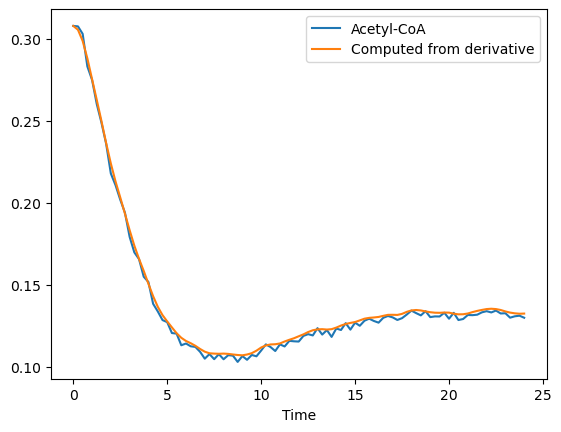

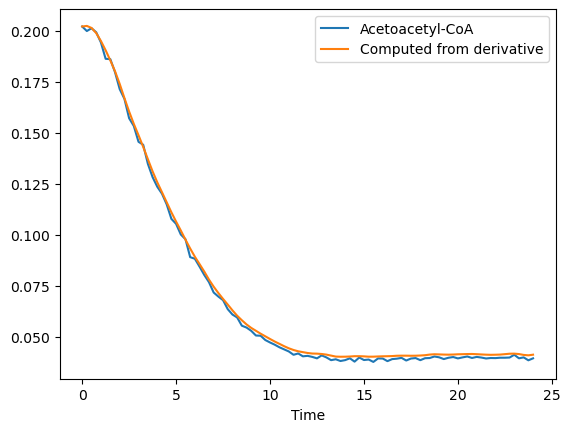

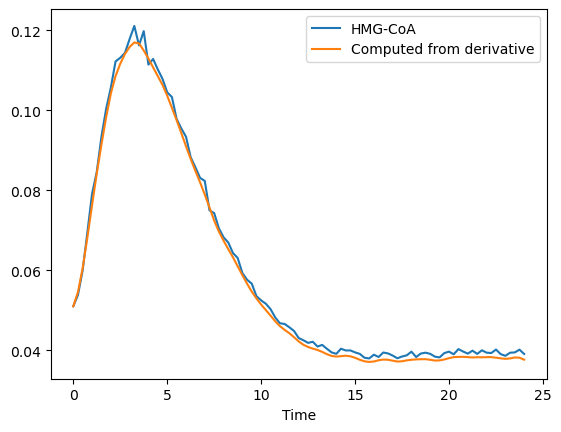

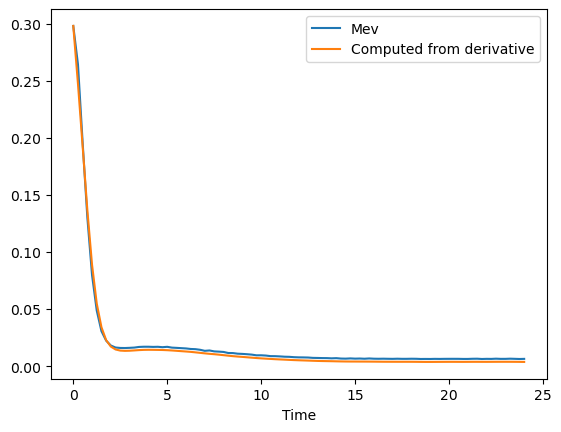

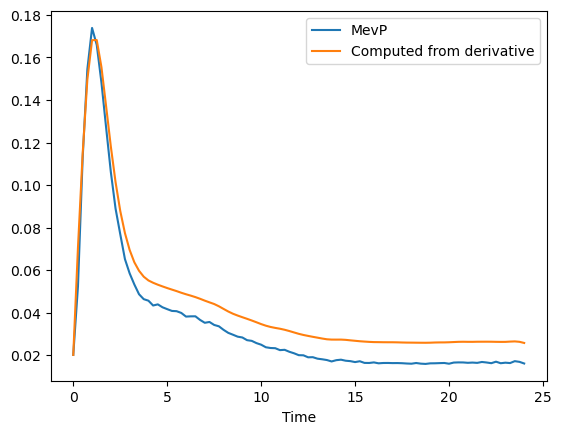

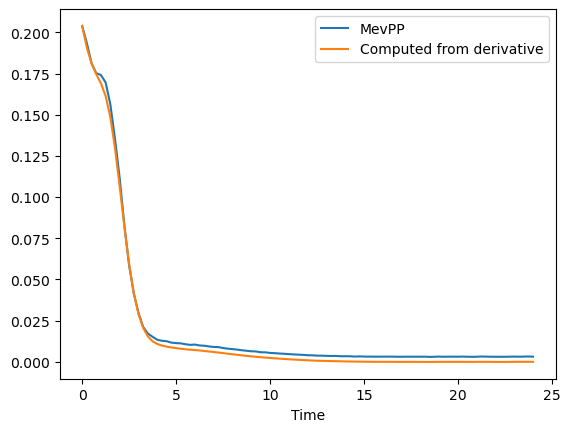

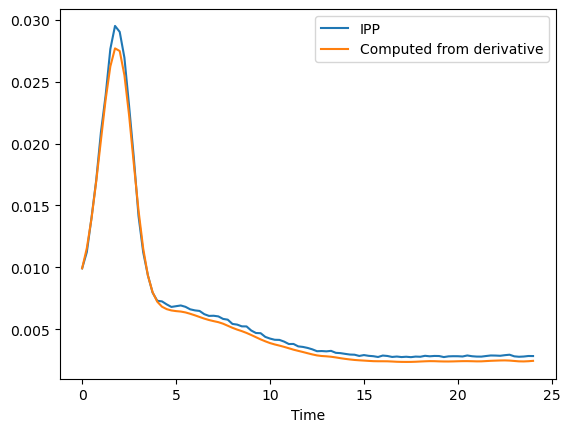

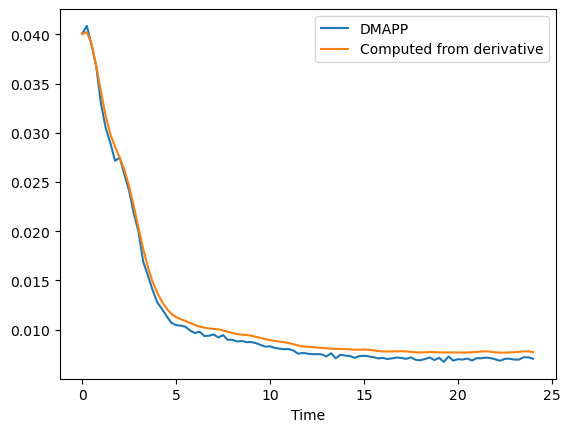

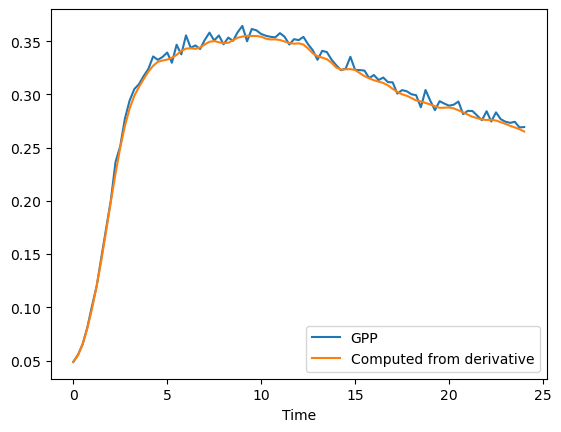

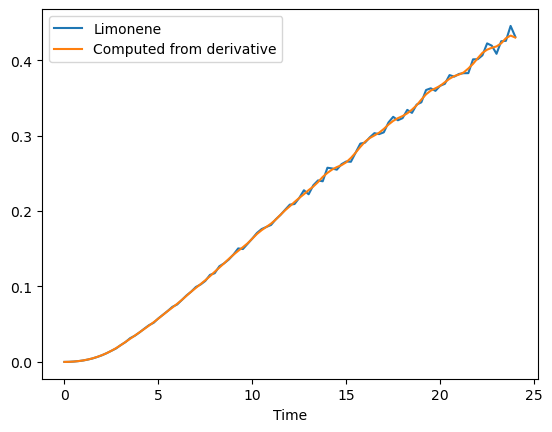

'Time profile from derivative vs. actual profile for Strain 2'

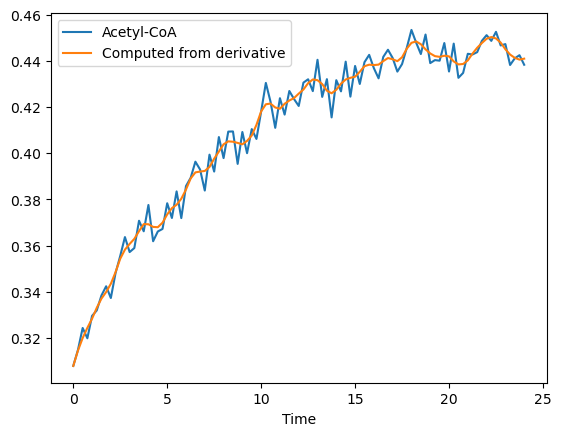

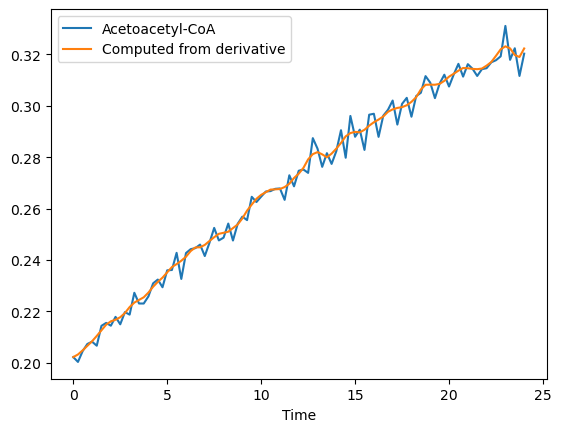

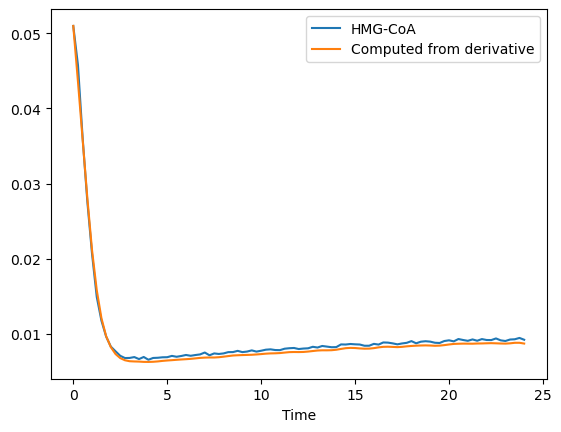

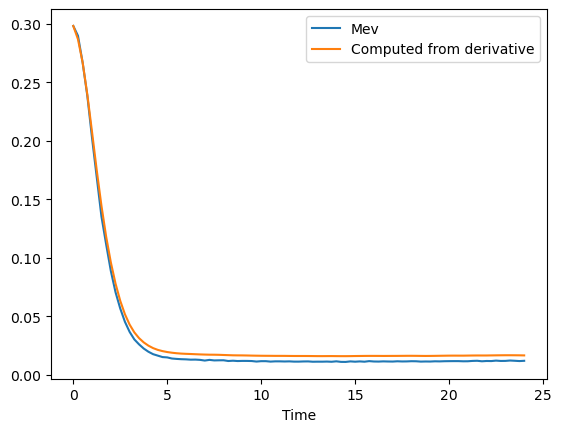

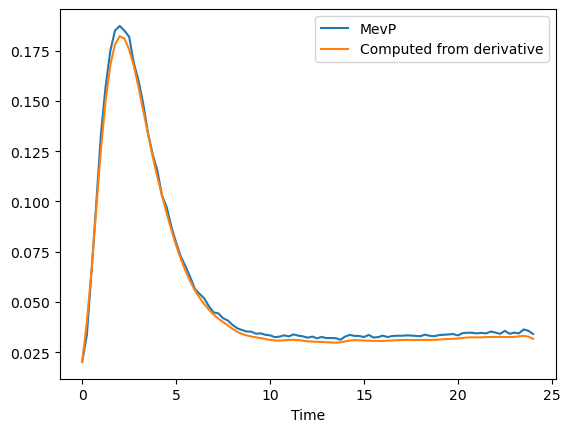

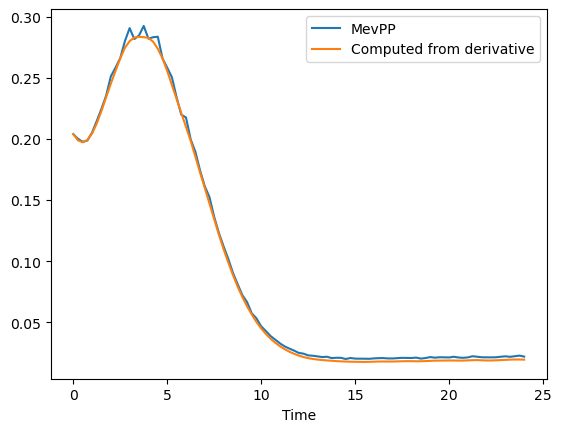

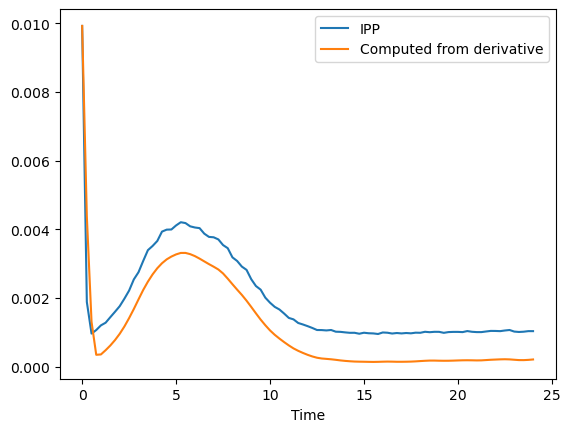

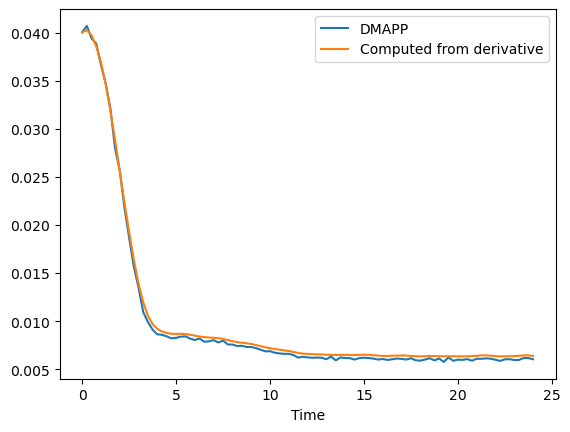

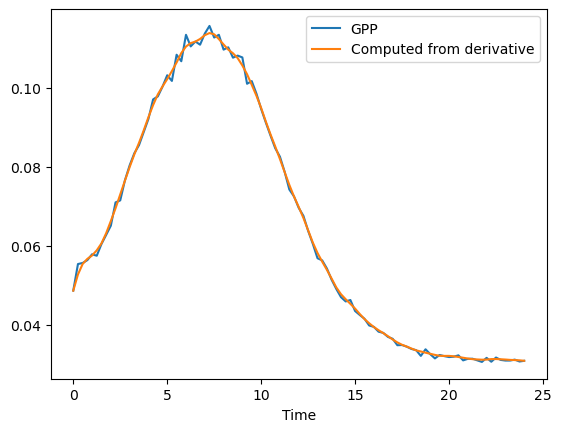

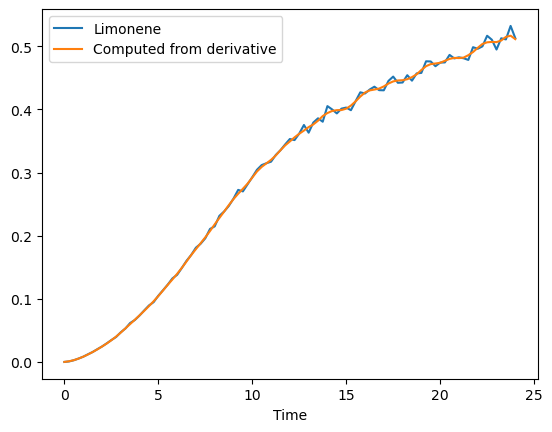

'Time profile from derivative vs. actual profile for Strain 3'

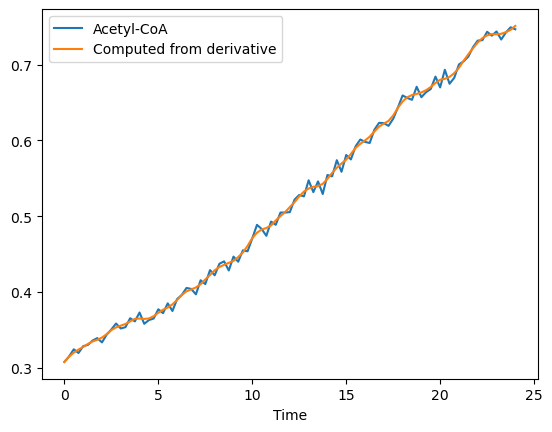

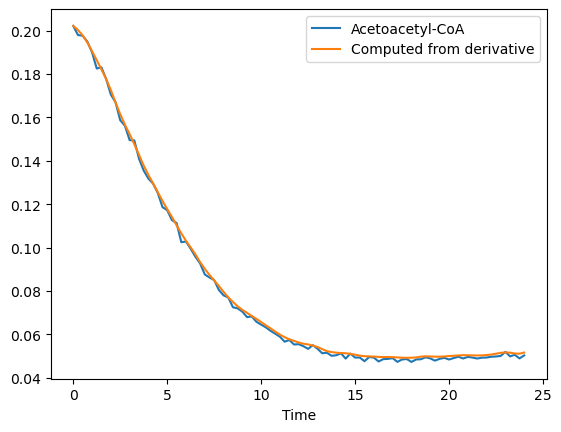

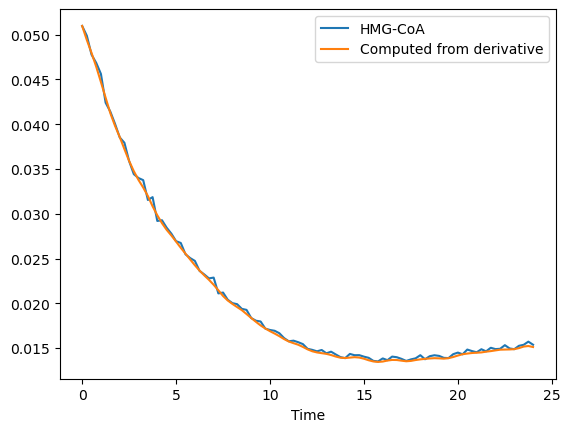

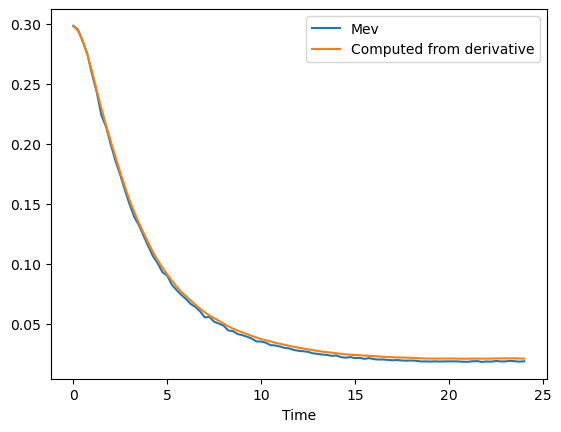

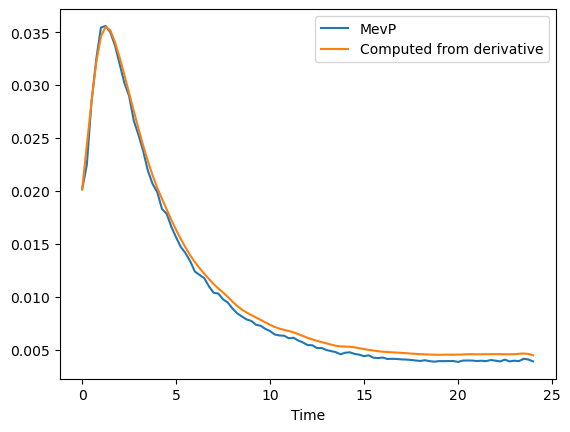

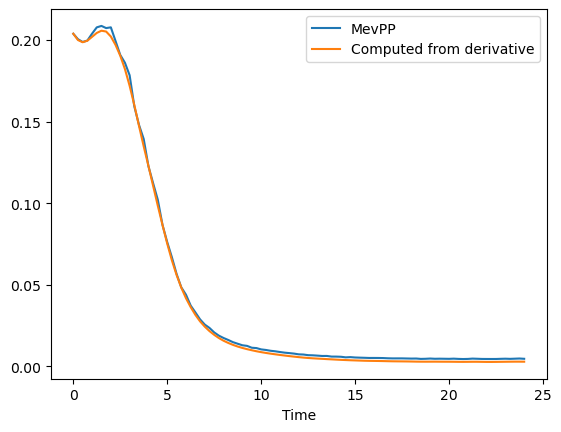

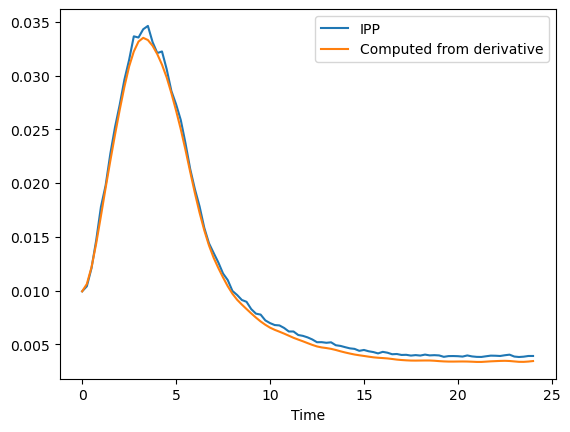

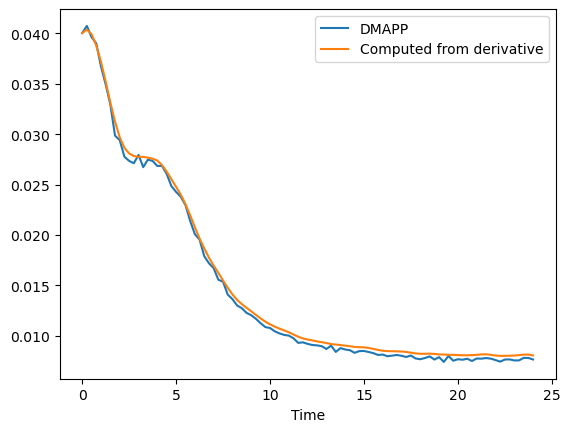

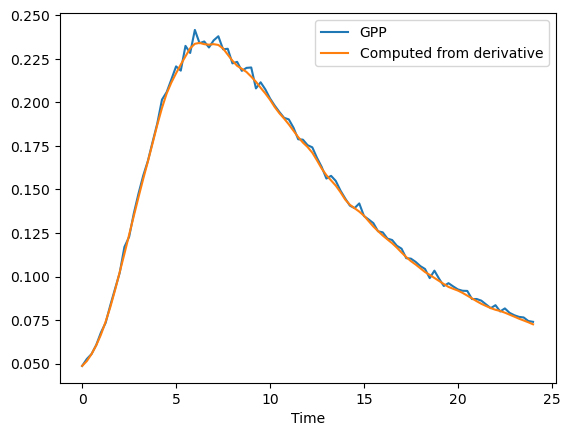

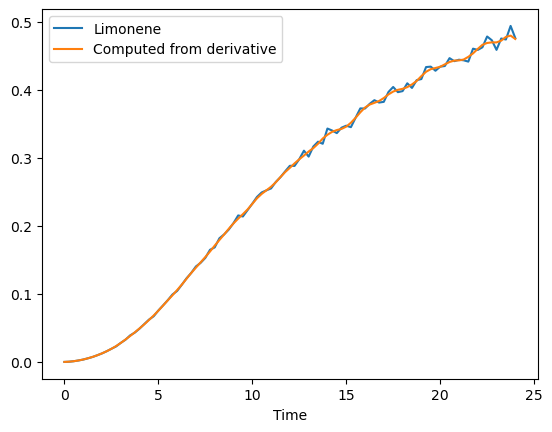

'Time profile from derivative vs. actual profile for WT'

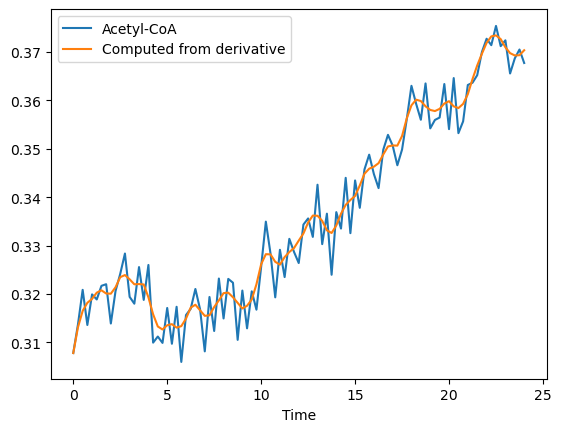

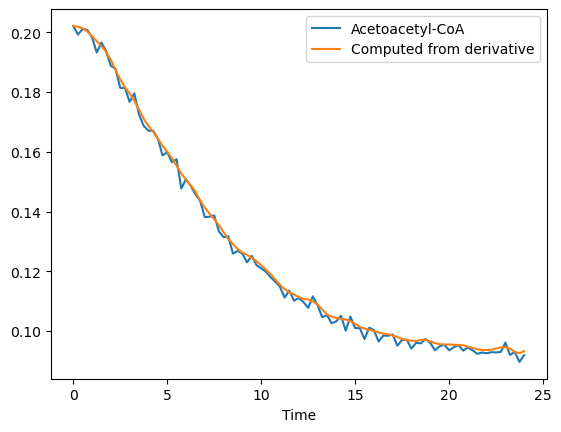

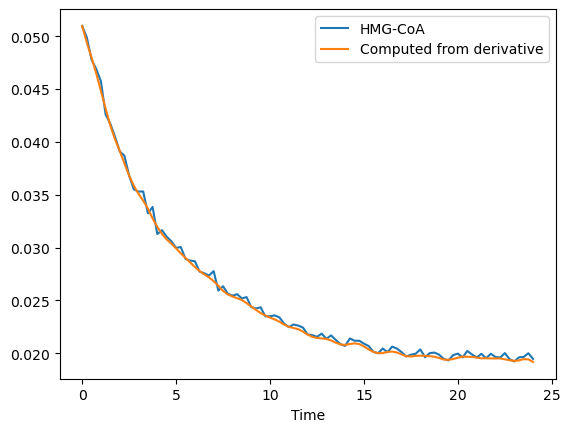

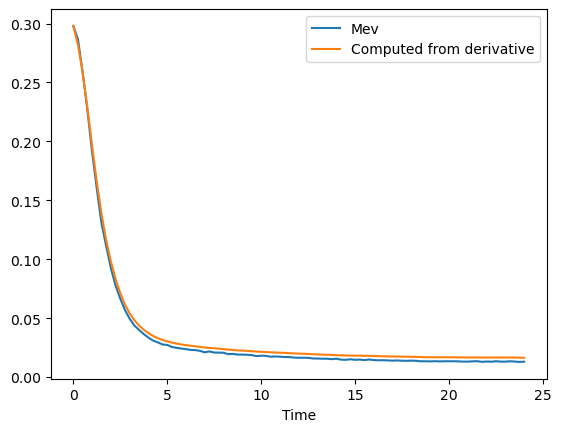

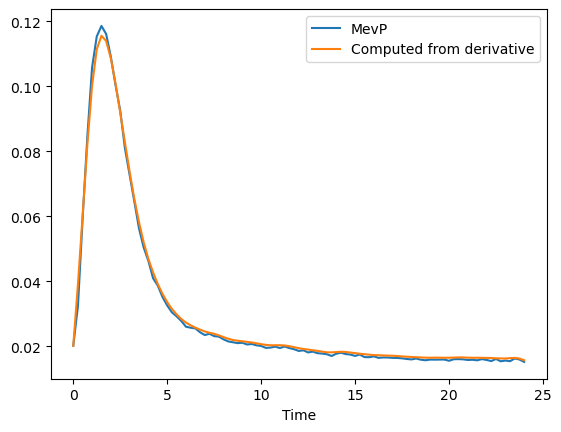

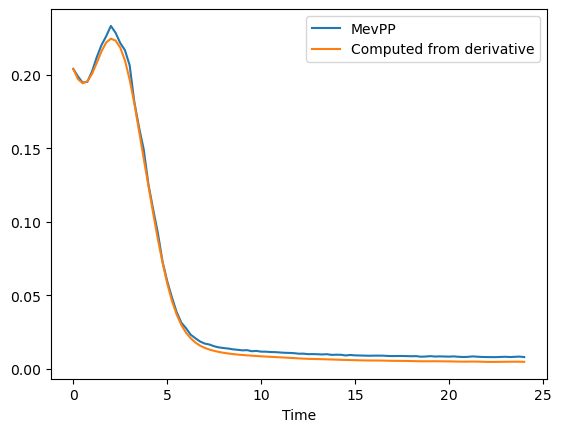

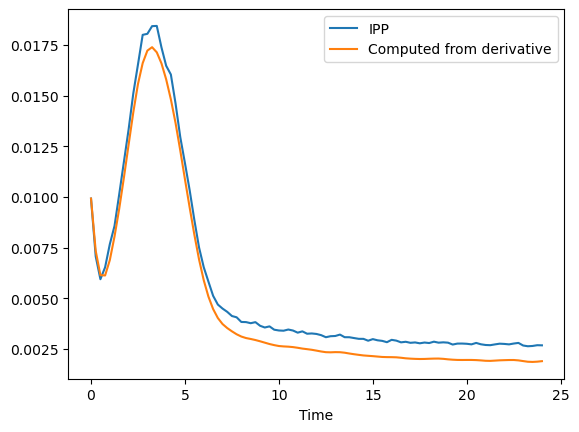

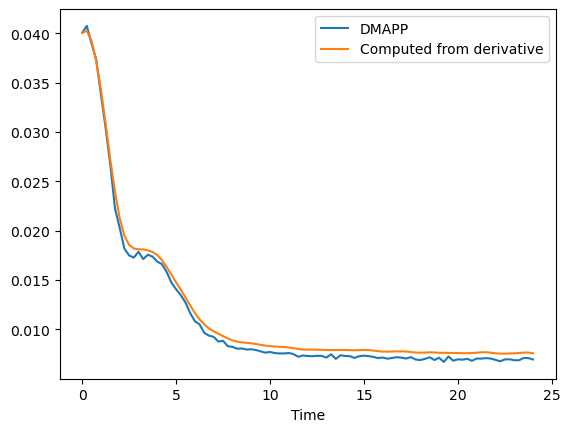

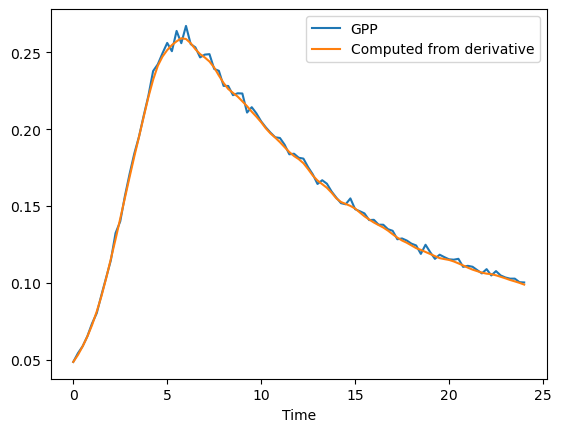

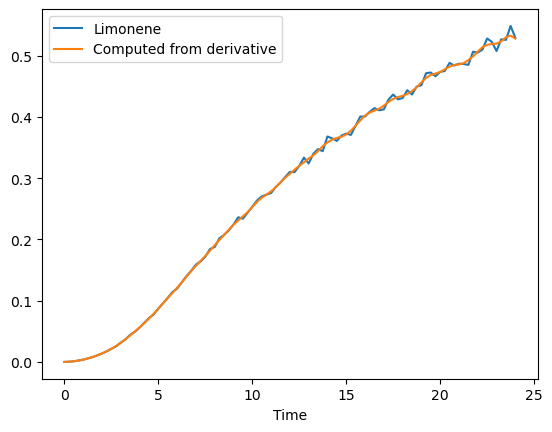

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.101863e+01  4.015845e+01  3.769282e+01  5.723769e+01   
         0.25   4.486963e+06  2.379775e+06  2.151706e+05  1.421525e+06   
         0.50   5.600547e+06  3.542830e+06  3.480314e+05  2.226925e+06   
         0.75   5.898077e+06  4.193526e+06  4.185394e+05  2.716502e+06   
         1.00   5.950154e+06  4.740187e+06  4.756117e+05  3.135893e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793985e+06  2.726634e+06  1.732866e+06  1.999582e+06   
         23.25  2.674277e+06  2.652135e+06  1.764617e+06  2.006932e+06   
         23.50  2.699014e+06  2.722133e+06  1.774984e+06  2.001659e+06   
         23.75  2.825522e+06  2.650638e+06  1.791724e+06  2.026817e+06   
         24.00  2.720292e+06  2.726081e+06  1.773775e+06  2.054542e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.679149e+01  5.554329e+01  5.504357e+01  1.870883e+01   
         0.25   4.724407e+05  2.249389e+06  2.613968e+06  4.271298e+05   
         0.50   7.129844e+05  3.752934e+06  3.280235e+06  6.385851e+05   
         0.75   8.861639e+05  4.752821e+06  3.593999e+06  7.611653e+05   
         1.00   9.916589e+05  5.524615e+06  3.766037e+06  8.471239e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.519758e+06  3.933723e+06  4.405661e+06  1.211293e+06   
         23.25  1.512951e+06  3.982947e+06  4.295628e+06  1.235920e+06   
         23.50  1.498116e+06  3.988023e+06  4.423044e+06  1.246005e+06   
         23.75  1.482534e+06  3.991343e+06  4.296578e+06  1.228846e+06   
         24.00  1.498900e+06  3.898759e+06  4.397311e+06  1.226257e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.955014e+01   0.307814        0.202156  0.050979   
         0.25       1.868839e+05   0.307536        0.199929  0.053825   
         0.50       2.787753e+05   0.302969        0.201308  0.060000   
         0.75       3.510419e+05   0.283090        0.199303  0.069457   
         1.00       4.039616e+05   0.274914        0.194288  0.079106   
...                          ...        ...             ...       ...   
WT       23.00      1.467980e+06   0.372369        0.096121  0.019218   
         23.25      1.460229e+06   0.365523        0.092006  0.019604   
         23.50      1.477857e+06   0.368637        0.093034  0.019644   
         23.75      1.494116e+06   0.370468        0.089665  0.019993   
         24.00      1.493358e+06   0.367688        0.091909  0.019458   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297995  0.020144  0.203898  0.009923  0.040045  0.048697   
         0.25   0.264342  0.052381  0.193532  0.011239  0.040850  0.055387   
         0.50   0.195479  0.112762  0.181202  0.014024  0.038906  0.065404   
         0.75   0.130116  0.154462  0.175223  0.017051  0.036721  0.081182   
         1.00   0.079675  0.173881  0.174100  0.020915  0.032977  0.101425   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.013121  0.015609  0.008199  0.002668  0.006879  0.103587   
         23.25  0.013424  0.015420  0.008012  0.002632  0.006877  0.102811   
         23.50  0.013161  0.016253  0.008165  0.002645  0.007107 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.000545        0.003694  0.009453 -0.193974  0.214470   
         0.25    -0.018322       -0.001425  0.019104 -0.211160  0.189146   
         0.50    -0.036099       -0.006545  0.028754 -0.228347  0.163822   
         0.75    -0.049114       -0.013704  0.032271 -0.218864  0.115252   
         1.00    -0.052495       -0.017341  0.032788 -0.164455  0.032889   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.007619       -0.000238 -0.000221 -0.000111  0.000140   
         23.25   -0.002051       -0.003888  0.000621 -0.000174  0.000692   
         23.50   -0.001768       -0.004306  0.000347 -0.000255 -0.000134   
         23.75    0.002146        0.000449 -0.000530 -0.000379 -0.001425   
         24.00    0.006060        0.005205 -0.001408 -0.000504 -0.002717   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.059549  0.005019  0.003367  0.014939  0.000064  
         0.25  -0.045356  0.008069 -0.001970  0.033720  0.000984  
         0.50  -0.031162  0.011119 -0.007306  0.052501  0.001904  
         0.75  -0.022003  0.012876 -0.010648  0.066323  0.002981  
         1.00  -0.022139  0.013621 -0.010425  0.081240  0.004119  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000133 -0.000162  0.000078 -0.004741 -0.000197  
         23.25  0.000168 -0.000100  0.000191 -0.003796  0.028033  
         23.50 -0.000034  0.000027  0.000149 -0.003512  0.026125  
         23.75 -0.000184  0.000075 -0.000150 -0.004166 -0.004151  
         24.00 -0.000334  0.000123 -0.000448 -0.004821 -0.034426  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem

# problem definition (object oriented to use population-based approach)
class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=34, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                         0.0,0.0,-1.30103,0.0                         
                         ]), # lower bounds
                         xu=np.array([
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,
                         9.0,9.0,-1.301029,9.0
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                      s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                      k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
                      k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
                      k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
        #HC: 53 parameters (9+10+12+12+10)
        r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
        r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
        r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
        r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
        r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
        r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
        r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
        r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
        r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
        
        return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e4)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.410598E+36 |  1.312761E+19
     2 |       74 |  1.832522E+19 |  2.677259E+16
     3 |      138 |  2.091843E+17 |  2.344293E+15
     4 |      202 |  1.306103E+15 |  4.376368E+12
     5 |      266 |  5.419619E+12 |  2.707535E+09
     6 |      330 |  1.364998E+12 |  2.707535E+09
     7 |      394 |  1.137469E+12 |  2.707535E+09
     8 |      458 |  1.702914E+10 |  6.703662E+08
     9 |      522 |  2.346412E+10 |  2.865430E+08
    10 |      586 |  5.815231E+09 |  2.718939E+08
    11 |      650 |  2.504946E+09 |  5.935642E+06
    12 |      714 |  1.712379E+08 |  4.409612E+06
    13 |      778 |  6.310948E+07 |  1.557517E+06
    14 |      842 |  1.906312E+07 |  3.020930E+05
    15 |      906 |  1.861707E+07 |  3.020930E+05
    16 |      970 |  1.657356E+07 |  3.020930E+05
    17 |     1034 |  5.225196E+06 |  3.020930E+05
    18 |     1098 |  1.748527E+06 |  2.031179E+05
    19 |     1162 |  1.293

   162 |    10314 |  2.259421E+01 |  2.035091E+01
   163 |    10378 |  2.176955E+01 |  1.927753E+01
   164 |    10442 |  2.134758E+01 |  1.914900E+01
   165 |    10506 |  2.103479E+01 |  1.914900E+01
   166 |    10570 |  2.104596E+01 |  1.914900E+01
   167 |    10634 |  2.143764E+01 |  1.914900E+01
   168 |    10698 |  2.152207E+01 |  1.914900E+01
   169 |    10762 |  2.059706E+01 |  1.871456E+01
   170 |    10826 |  1.988718E+01 |  1.871456E+01
   171 |    10890 |  1.940676E+01 |  1.833751E+01
   172 |    10954 |  1.915536E+01 |  1.778296E+01
   173 |    11018 |  1.904324E+01 |  1.650308E+01
   174 |    11082 |  1.882861E+01 |  1.650308E+01
   175 |    11146 |  1.883794E+01 |  1.650308E+01
   176 |    11210 |  1.983611E+01 |  1.650308E+01
   177 |    11274 |  1.902099E+01 |  1.650308E+01
   178 |    11338 |  1.777716E+01 |  1.650308E+01
   179 |    11402 |  1.734605E+01 |  1.633069E+01
   180 |    11466 |  1.774463E+01 |  1.633069E+01
   181 |    11530 |  1.772391E+01 |  1.633069E+01


   326 |    20810 |  7.8352586350 |  7.6705832728
   327 |    20874 |  7.7676090814 |  7.6705832728
   328 |    20938 |  7.7105052951 |  7.5555575380
   329 |    21002 |  7.6404062274 |  7.4815438656
   330 |    21066 |  7.5800332978 |  7.4026112727
   331 |    21130 |  7.4909740235 |  7.4026112727
   332 |    21194 |  7.4723498392 |  7.3673981172
   333 |    21258 |  7.4099972689 |  7.3404574355
   334 |    21322 |  7.3841880616 |  7.3310861815
   335 |    21386 |  7.3566202172 |  7.1822826382
   336 |    21450 |  7.2591634833 |  7.1328628482
   337 |    21514 |  7.1926020856 |  7.0974493995
   338 |    21578 |  7.1278541181 |  7.0768918928
   339 |    21642 |  7.0847022225 |  7.0136587837
   340 |    21706 |  7.0245560155 |  6.9119634749
   341 |    21770 |  6.9637114077 |  6.8771729533
   342 |    21834 |  6.9320003608 |  6.8561871626
   343 |    21898 |  6.8761569648 |  6.7616142754
   344 |    21962 |  6.7820396553 |  6.6126982125
   345 |    22026 |  6.6507968780 |  6.5349688716


   490 |    31306 |  4.9867297718 |  4.9737539471
   491 |    31370 |  4.9821570941 |  4.9733666107
   492 |    31434 |  4.9765270117 |  4.9686449729
   493 |    31498 |  4.9716872180 |  4.9684145721
   494 |    31562 |  4.9724956422 |  4.9674760369
   495 |    31626 |  4.9715857938 |  4.9570826159
   496 |    31690 |  4.9650367563 |  4.9570826159
   497 |    31754 |  4.9632022636 |  4.9530430492
   498 |    31818 |  4.9619920985 |  4.9514960739
   499 |    31882 |  4.9569528632 |  4.9495131318
   500 |    31946 |  4.9569612171 |  4.9495131318
   501 |    32010 |  4.9561722890 |  4.9491570098
   502 |    32074 |  4.9565369817 |  4.9436714585
   503 |    32138 |  4.9538183310 |  4.9436714585
   504 |    32202 |  4.9550904847 |  4.9436714585
   505 |    32266 |  4.9527868973 |  4.9436714585
   506 |    32330 |  4.9542185785 |  4.9436714585
   507 |    32394 |  4.9539960635 |  4.9436714585
   508 |    32458 |  4.9547398175 |  4.9436714585
   509 |    32522 |  4.9553596885 |  4.9436714585


   654 |    41802 |  4.8595938241 |  4.8545541029
   655 |    41866 |  4.8592262211 |  4.8545541029
   656 |    41930 |  4.8569970225 |  4.8526518283
   657 |    41994 |  4.8552873599 |  4.8513914230
   658 |    42058 |  4.8546703884 |  4.8496633709
   659 |    42122 |  4.8520072803 |  4.8481284111
   660 |    42186 |  4.8508067236 |  4.8474909125
   661 |    42250 |  4.8509083014 |  4.8458537069
   662 |    42314 |  4.8493121304 |  4.8445827387
   663 |    42378 |  4.8493516545 |  4.8445827387
   664 |    42442 |  4.8478353096 |  4.8425087325
   665 |    42506 |  4.8466140637 |  4.8388355412
   666 |    42570 |  4.8449323092 |  4.8372854122
   667 |    42634 |  4.8441020236 |  4.8372854122
   668 |    42698 |  4.8446687329 |  4.8372854122
   669 |    42762 |  4.8439669279 |  4.8372854122
   670 |    42826 |  4.8459879320 |  4.8372854122
   671 |    42890 |  4.8459896739 |  4.8372854122
   672 |    42954 |  4.8440624745 |  4.8372854122
   673 |    43018 |  4.8443256835 |  4.8372854122


   818 |    52298 |  4.8075425172 |  4.8070588313
   819 |    52362 |  4.8074436893 |  4.8068095051
   820 |    52426 |  4.8072872348 |  4.8068095051
   821 |    52490 |  4.8071863267 |  4.8066897332
   822 |    52554 |  4.8070114971 |  4.8064744479
   823 |    52618 |  4.8068842990 |  4.8064744479
   824 |    52682 |  4.8067835641 |  4.8061977285
   825 |    52746 |  4.8066398620 |  4.8061977285
   826 |    52810 |  4.8064694797 |  4.8061141141
   827 |    52874 |  4.8064740036 |  4.8061141141
   828 |    52938 |  4.8065033595 |  4.8061141141
   829 |    53002 |  4.8045502130 |  4.7970525405
   830 |    53066 |  4.8007735672 |  4.7970525405
   831 |    53130 |  4.7950749460 |  4.7910158359
   832 |    53194 |  4.7931771906 |  4.7909934662
   833 |    53258 |  4.7925055524 |  4.7907841991
   834 |    53322 |  4.7932489720 |  4.7907327800
   835 |    53386 |  4.7921457377 |  4.7891688347
   836 |    53450 |  4.7909683920 |  4.7886717157
   837 |    53514 |  4.7900548213 |  4.7873674769


   982 |    62794 |  4.4878729778 |  4.4860541801
   983 |    62858 |  4.4874506499 |  4.4858224392
   984 |    62922 |  4.4867842410 |  4.4851770305
   985 |    62986 |  4.4862439844 |  4.4851232816
   986 |    63050 |  4.4859715779 |  4.4845257087
   987 |    63114 |  4.4855382082 |  4.4836687516
   988 |    63178 |  4.4844927404 |  4.4828746171
   989 |    63242 |  4.4832609033 |  4.4825506895
   990 |    63306 |  4.4830352175 |  4.4819989769
   991 |    63370 |  4.4826264126 |  4.4814357405
   992 |    63434 |  4.4820013873 |  4.4811732134
   993 |    63498 |  4.4817671209 |  4.4811732134
   994 |    63562 |  4.4817939250 |  4.4810613706
   995 |    63626 |  4.4816738019 |  4.4810613706
   996 |    63690 |  4.4816355941 |  4.4809567548
   997 |    63754 |  4.4816604435 |  4.4803805446
   998 |    63818 |  4.4808365295 |  4.4801737829
   999 |    63882 |  4.4807051875 |  4.4800972563
  1000 |    63946 |  4.4805626914 |  4.4797117539
  1001 |    64010 |  4.4805389384 |  4.4797117539


  1146 |    73290 |  4.4472953563 |  4.4470893652
  1147 |    73354 |  4.4472270666 |  4.4470893652
  1148 |    73418 |  4.4471960688 |  4.4470893652
  1149 |    73482 |  4.4472284127 |  4.4470893652
  1150 |    73546 |  4.4471575514 |  4.4470029614
  1151 |    73610 |  4.4471257451 |  4.4470029614
  1152 |    73674 |  4.4470659328 |  4.4468896412
  1153 |    73738 |  4.4469792280 |  4.4468544688
  1154 |    73802 |  4.4469062569 |  4.4468292987
  1155 |    73866 |  4.4468254196 |  4.4466820918
  1156 |    73930 |  4.4467441056 |  4.4466139825
  1157 |    73994 |  4.4467210183 |  4.4465812113
  1158 |    74058 |  4.4466596433 |  4.4465343239
  1159 |    74122 |  4.4465871220 |  4.4464772123
  1160 |    74186 |  4.4465247832 |  4.4464768957
  1161 |    74250 |  4.4464911835 |  4.4463685821
  1162 |    74314 |  4.4464675400 |  4.4463685821
  1163 |    74378 |  4.4464638592 |  4.4463685821
  1164 |    74442 |  4.4464392504 |  4.4463674682
  1165 |    74506 |  4.4464135400 |  4.4463588461


  1310 |    83786 |  4.4454002659 |  4.4453871856
  1311 |    83850 |  4.4453943414 |  4.4453847251
  1312 |    83914 |  4.4453901604 |  4.4453847251
  1313 |    83978 |  4.4453853966 |  4.4453790042
  1314 |    84042 |  4.4453808074 |  4.4453728338
  1315 |    84106 |  4.4453774715 |  4.4453728338
  1316 |    84170 |  4.4453734440 |  4.4453689778
  1317 |    84234 |  4.4453692159 |  4.4453635242
  1318 |    84298 |  4.4453682588 |  4.4453624663
  1319 |    84362 |  4.4453643421 |  4.4453575526
  1320 |    84426 |  4.4453630808 |  4.4453551757
  1321 |    84490 |  4.4453573881 |  4.4453497253
  1322 |    84554 |  4.4453520242 |  4.4453449387
  1323 |    84618 |  4.4453487840 |  4.4453403350
  1324 |    84682 |  4.4453453695 |  4.4453330929
  1325 |    84746 |  4.4453396893 |  4.4453322021
  1326 |    84810 |  4.4453331312 |  4.4453241883
  1327 |    84874 |  4.4453258621 |  4.4453189360
  1328 |    84938 |  4.4453207400 |  4.4453145820
  1329 |    85002 |  4.4453206001 |  4.4453145820


  1474 |    94282 |  4.4451280580 |  4.4451260015
  1475 |    94346 |  4.4451277194 |  4.4451260015
  1476 |    94410 |  4.4451272606 |  4.4451249454
  1477 |    94474 |  4.4451273213 |  4.4451249454
  1478 |    94538 |  4.4451272414 |  4.4451249454
  1479 |    94602 |  4.4451267463 |  4.4451249454
  1480 |    94666 |  4.4451260562 |  4.4451240848
  1481 |    94730 |  4.4451260904 |  4.4451240848
  1482 |    94794 |  4.4451262054 |  4.4451240848
  1483 |    94858 |  4.4451257380 |  4.4451240848
  1484 |    94922 |  4.4451257938 |  4.4451240848
  1485 |    94986 |  4.4451255780 |  4.4451240848
  1486 |    95050 |  4.4451253045 |  4.4451240848
  1487 |    95114 |  4.4451254035 |  4.4451228474
  1488 |    95178 |  4.4451256015 |  4.4451228474
  1489 |    95242 |  4.4451262744 |  4.4451228474
  1490 |    95306 |  4.4451254909 |  4.4451228474
  1491 |    95370 |  4.4451247337 |  4.4451228474
  1492 |    95434 |  4.4451246400 |  4.4451228474
  1493 |    95498 |  4.4451250994 |  4.4451228474


  1638 |   104778 |  4.4451089632 |  4.4451087877
  1639 |   104842 |  4.4451089415 |  4.4451087877
  1640 |   104906 |  4.4451089452 |  4.4451087877
  1641 |   104970 |  4.4451089013 |  4.4451087877
  1642 |   105034 |  4.4451088835 |  4.4451087877
  1643 |   105098 |  4.4451088607 |  4.4451087138
  1644 |   105162 |  4.4451088847 |  4.4451087138
  1645 |   105226 |  4.4451088365 |  4.4451087138
  1646 |   105290 |  4.4451088084 |  4.4451086821
  1647 |   105354 |  4.4451087797 |  4.4451086292
  1648 |   105418 |  4.4451086911 |  4.4451086292
  1649 |   105482 |  4.4451086572 |  4.4451085544
  1650 |   105546 |  4.4451085933 |  4.4451084334
  1651 |   105610 |  4.4451085349 |  4.4451083902
  1652 |   105674 |  4.4451084982 |  4.4451083902
  1653 |   105738 |  4.4451084477 |  4.4451082886
  1654 |   105802 |  4.4451084114 |  4.4451082886
  1655 |   105866 |  4.4451083988 |  4.4451082886
  1656 |   105930 |  4.4451084128 |  4.4451082886
  1657 |   105994 |  4.4451083795 |  4.4451082700


  1802 |   115274 |  4.4451068860 |  4.4451068484
  1803 |   115338 |  4.4451068908 |  4.4451068484
  1804 |   115402 |  4.4451068947 |  4.4451068484
  1805 |   115466 |  4.4451068898 |  4.4451068484
  1806 |   115530 |  4.4451068856 |  4.4451068484
  1807 |   115594 |  4.4451068951 |  4.4451068484
  1808 |   115658 |  4.4451068966 |  4.4451068484
  1809 |   115722 |  4.4451069013 |  4.4451068484
  1810 |   115786 |  4.4451068895 |  4.4451068484
  1811 |   115850 |  4.4451068900 |  4.4451068484
  1812 |   115914 |  4.4451068913 |  4.4451068484
  1813 |   115978 |  4.4451068803 |  4.4451068484
  1814 |   116042 |  4.4451068727 |  4.4451068439
  1815 |   116106 |  4.4451068830 |  4.4451068439
  1816 |   116170 |  4.4451068803 |  4.4451068439
  1817 |   116234 |  4.4451068791 |  4.4451068439
  1818 |   116298 |  4.4451068721 |  4.4451068439
  1819 |   116362 |  4.4451068680 |  4.4451068439
  1820 |   116426 |  4.4451068625 |  4.4451068439
  1821 |   116490 |  4.4451068642 |  4.4451068439


  1966 |   125770 |  4.4451068046 |  4.4451068037
  1967 |   125834 |  4.4451068043 |  4.4451068032
  1968 |   125898 |  4.4451068041 |  4.4451068032
  1969 |   125962 |  4.4451068040 |  4.4451068032
  1970 |   126026 |  4.4451068038 |  4.4451068032
  1971 |   126090 |  4.4451068036 |  4.4451068028
  1972 |   126154 |  4.4451068037 |  4.4451068028
  1973 |   126218 |  4.4451068034 |  4.4451068025
  1974 |   126282 |  4.4451068027 |  4.4451068020
  1975 |   126346 |  4.4451068021 |  4.4451068015
  1976 |   126410 |  4.4451068019 |  4.4451068007
  1977 |   126474 |  4.4451068017 |  4.4451068007
  1978 |   126538 |  4.4451068010 |  4.4451068003
  1979 |   126602 |  4.4451068004 |  4.4451067994
  1980 |   126666 |  4.4451067997 |  4.4451067993
  1981 |   126730 |  4.4451067995 |  4.4451067992
  1982 |   126794 |  4.4451067994 |  4.4451067988
  1983 |   126858 |  4.4451067990 |  4.4451067985
  1984 |   126922 |  4.4451067989 |  4.4451067984
  1985 |   126986 |  4.4451067987 |  4.4451067981


  2130 |   136266 |  4.4451067854 |  4.4451067851
  2131 |   136330 |  4.4451067852 |  4.4451067850
  2132 |   136394 |  4.4451067853 |  4.4451067850
  2133 |   136458 |  4.4451067853 |  4.4451067850
  2134 |   136522 |  4.4451067853 |  4.4451067850
  2135 |   136586 |  4.4451067852 |  4.4451067848
  2136 |   136650 |  4.4451067851 |  4.4451067848
  2137 |   136714 |  4.4451067851 |  4.4451067846
  2138 |   136778 |  4.4451067850 |  4.4451067846
  2139 |   136842 |  4.4451067849 |  4.4451067844
  2140 |   136906 |  4.4451067848 |  4.4451067844
  2141 |   136970 |  4.4451067847 |  4.4451067844
  2142 |   137034 |  4.4451067846 |  4.4451067844
  2143 |   137098 |  4.4451067846 |  4.4451067844
  2144 |   137162 |  4.4451067844 |  4.4451067842
  2145 |   137226 |  4.4451067845 |  4.4451067842
  2146 |   137290 |  4.4451067844 |  4.4451067842
  2147 |   137354 |  4.4451067842 |  4.4451067840
  2148 |   137418 |  4.4451067842 |  4.4451067840
  2149 |   137482 |  4.4451067842 |  4.4451067840


  2294 |   146762 |  4.4451067798 |  4.4451067798
  2295 |   146826 |  4.4451067798 |  4.4451067798
  2296 |   146890 |  4.4451067798 |  4.4451067798
  2297 |   146954 |  4.4451067798 |  4.4451067798
  2298 |   147018 |  4.4451067798 |  4.4451067798
  2299 |   147082 |  4.4451067798 |  4.4451067798
  2300 |   147146 |  4.4451067798 |  4.4451067798
  2301 |   147210 |  4.4451067798 |  4.4451067798
  2302 |   147274 |  4.4451067798 |  4.4451067798
  2303 |   147338 |  4.4451067798 |  4.4451067798
  2304 |   147402 |  4.4451067798 |  4.4451067798
  2305 |   147466 |  4.4451067798 |  4.4451067798
  2306 |   147530 |  4.4451067798 |  4.4451067798
  2307 |   147594 |  4.4451067798 |  4.4451067798
  2308 |   147658 |  4.4451067798 |  4.4451067798
  2309 |   147722 |  4.4451067798 |  4.4451067798
  2310 |   147786 |  4.4451067798 |  4.4451067798
  2311 |   147850 |  4.4451067798 |  4.4451067798
  2312 |   147914 |  4.4451067798 |  4.4451067798
  2313 |   147978 |  4.4451067798 |  4.4451067798


  2458 |   157258 |  4.4451067790 |  4.4451067789
  2459 |   157322 |  4.4451067790 |  4.4451067789
  2460 |   157386 |  4.4451067789 |  4.4451067789
  2461 |   157450 |  4.4451067789 |  4.4451067789
  2462 |   157514 |  4.4451067789 |  4.4451067789
  2463 |   157578 |  4.4451067789 |  4.4451067789
  2464 |   157642 |  4.4451067789 |  4.4451067789
  2465 |   157706 |  4.4451067789 |  4.4451067789
  2466 |   157770 |  4.4451067789 |  4.4451067789
  2467 |   157834 |  4.4451067789 |  4.4451067789
  2468 |   157898 |  4.4451067789 |  4.4451067789
  2469 |   157962 |  4.4451067789 |  4.4451067789
  2470 |   158026 |  4.4451067789 |  4.4451067789
  2471 |   158090 |  4.4451067789 |  4.4451067789
  2472 |   158154 |  4.4451067789 |  4.4451067789
  2473 |   158218 |  4.4451067789 |  4.4451067789
  2474 |   158282 |  4.4451067789 |  4.4451067788
  2475 |   158346 |  4.4451067788 |  4.4451067788
  2476 |   158410 |  4.4451067788 |  4.4451067788
  2477 |   158474 |  4.4451067788 |  4.4451067788


  2622 |   167754 |  4.4451067777 |  4.4451067777
  2623 |   167818 |  4.4451067777 |  4.4451067777
  2624 |   167882 |  4.4451067777 |  4.4451067777
  2625 |   167946 |  4.4451067777 |  4.4451067777
  2626 |   168010 |  4.4451067777 |  4.4451067777
  2627 |   168074 |  4.4451067777 |  4.4451067777
  2628 |   168138 |  4.4451067777 |  4.4451067777
  2629 |   168202 |  4.4451067777 |  4.4451067777
  2630 |   168266 |  4.4451067777 |  4.4451067777
  2631 |   168330 |  4.4451067777 |  4.4451067777
  2632 |   168394 |  4.4451067777 |  4.4451067777
  2633 |   168458 |  4.4451067777 |  4.4451067777
  2634 |   168522 |  4.4451067777 |  4.4451067777
  2635 |   168586 |  4.4451067777 |  4.4451067777
  2636 |   168650 |  4.4451067777 |  4.4451067777
  2637 |   168714 |  4.4451067777 |  4.4451067777
  2638 |   168778 |  4.4451067777 |  4.4451067777
  2639 |   168842 |  4.4451067777 |  4.4451067776
  2640 |   168906 |  4.4451067777 |  4.4451067776
  2641 |   168970 |  4.4451067777 |  4.4451067776


  2786 |   178250 |  4.4451067776 |  4.4451067776
  2787 |   178314 |  4.4451067776 |  4.4451067776
  2788 |   178378 |  4.4451067776 |  4.4451067776
  2789 |   178442 |  4.4451067776 |  4.4451067776
  2790 |   178506 |  4.4451067776 |  4.4451067776
  2791 |   178570 |  4.4451067776 |  4.4451067776
  2792 |   178634 |  4.4451067776 |  4.4451067776
  2793 |   178698 |  4.4451067776 |  4.4451067776
  2794 |   178762 |  4.4451067776 |  4.4451067776
  2795 |   178826 |  4.4451067776 |  4.4451067776
  2796 |   178890 |  4.4451067776 |  4.4451067776
  2797 |   178954 |  4.4451067776 |  4.4451067776
  2798 |   179018 |  4.4451067776 |  4.4451067776
  2799 |   179082 |  4.4451067776 |  4.4451067776
  2800 |   179146 |  4.4451067776 |  4.4451067776
  2801 |   179210 |  4.4451067776 |  4.4451067776
  2802 |   179274 |  4.4451067776 |  4.4451067776
  2803 |   179338 |  4.4451067776 |  4.4451067776
  2804 |   179402 |  4.4451067776 |  4.4451067776
  2805 |   179466 |  4.4451067776 |  4.4451067776


  2950 |   188746 |  4.4451067775 |  4.4451067775
  2951 |   188810 |  4.4451067775 |  4.4451067775
  2952 |   188874 |  4.4451067775 |  4.4451067775
  2953 |   188938 |  4.4451067775 |  4.4451067775
  2954 |   189002 |  4.4451067775 |  4.4451067775
  2955 |   189066 |  4.4451067775 |  4.4451067775
  2956 |   189130 |  4.4451067775 |  4.4451067775
  2957 |   189194 |  4.4451067775 |  4.4451067775
  2958 |   189258 |  4.4451067775 |  4.4451067775
  2959 |   189322 |  4.4451067775 |  4.4451067775
  2960 |   189386 |  4.4451067775 |  4.4451067775
  2961 |   189450 |  4.4451067775 |  4.4451067775
  2962 |   189514 |  4.4451067775 |  4.4451067775
  2963 |   189578 |  4.4451067775 |  4.4451067775
  2964 |   189642 |  4.4451067775 |  4.4451067775
  2965 |   189706 |  4.4451067775 |  4.4451067775
  2966 |   189770 |  4.4451067775 |  4.4451067775
  2967 |   189834 |  4.4451067775 |  4.4451067775
  2968 |   189898 |  4.4451067775 |  4.4451067775
  2969 |   189962 |  4.4451067775 |  4.4451067775


  3114 |   199242 |  4.4451067775 |  4.4451067775
  3115 |   199306 |  4.4451067775 |  4.4451067775
  3116 |   199370 |  4.4451067775 |  4.4451067775
  3117 |   199434 |  4.4451067775 |  4.4451067775
  3118 |   199498 |  4.4451067775 |  4.4451067775
  3119 |   199562 |  4.4451067775 |  4.4451067775
  3120 |   199626 |  4.4451067775 |  4.4451067775
  3121 |   199690 |  4.4451067775 |  4.4451067775
  3122 |   199754 |  4.4451067775 |  4.4451067775
  3123 |   199818 |  4.4451067775 |  4.4451067775
  3124 |   199882 |  4.4451067775 |  4.4451067775
  3125 |   199946 |  4.4451067775 |  4.4451067775
  3126 |   200010 |  4.4451067775 |  4.4451067775
  3127 |   200074 |  4.4451067775 |  4.4451067775
  3128 |   200138 |  4.4451067775 |  4.4451067775
  3129 |   200202 |  4.4451067775 |  4.4451067775
  3130 |   200266 |  4.4451067775 |  4.4451067775
  3131 |   200330 |  4.4451067775 |  4.4451067775
  3132 |   200394 |  4.4451067775 |  4.4451067775
  3133 |   200458 |  4.4451067775 |  4.4451067775


  3278 |   209738 |  4.4451067775 |  4.4451067775
  3279 |   209802 |  4.4451067775 |  4.4451067775
  3280 |   209866 |  4.4451067775 |  4.4451067775
  3281 |   209930 |  4.4451067775 |  4.4451067775
  3282 |   209994 |  4.4451067775 |  4.4451067775
  3283 |   210058 |  4.4451067775 |  4.4451067775
  3284 |   210122 |  4.4451067775 |  4.4451067775
  3285 |   210186 |  4.4451067775 |  4.4451067775
  3286 |   210250 |  4.4451067775 |  4.4451067775
  3287 |   210314 |  4.4451067775 |  4.4451067775
  3288 |   210378 |  4.4451067775 |  4.4451067775
  3289 |   210442 |  4.4451067775 |  4.4451067775
  3290 |   210506 |  4.4451067775 |  4.4451067775
  3291 |   210570 |  4.4451067775 |  4.4451067775
  3292 |   210634 |  4.4451067775 |  4.4451067775
  3293 |   210698 |  4.4451067775 |  4.4451067775
  3294 |   210762 |  4.4451067775 |  4.4451067775
  3295 |   210826 |  4.4451067775 |  4.4451067775
  3296 |   210890 |  4.4451067775 |  4.4451067775
  3297 |   210954 |  4.4451067775 |  4.4451067775


  3442 |   220234 |  4.4451067775 |  4.4451067775
  3443 |   220298 |  4.4451067775 |  4.4451067775
  3444 |   220362 |  4.4451067775 |  4.4451067775
  3445 |   220426 |  4.4451067775 |  4.4451067775
  3446 |   220490 |  4.4451067775 |  4.4451067775
  3447 |   220554 |  4.4451067775 |  4.4451067775
  3448 |   220618 |  4.4451067775 |  4.4451067775
  3449 |   220682 |  4.4451067775 |  4.4451067775
  3450 |   220746 |  4.4451067775 |  4.4451067775
  3451 |   220810 |  4.4451067775 |  4.4451067775
  3452 |   220874 |  4.4451067775 |  4.4451067775
  3453 |   220938 |  4.4451067775 |  4.4451067775
  3454 |   221002 |  4.4451067775 |  4.4451067775
  3455 |   221066 |  4.4451067775 |  4.4451067775
  3456 |   221130 |  4.4451067775 |  4.4451067775
  3457 |   221194 |  4.4451067775 |  4.4451067775
  3458 |   221258 |  4.4451067775 |  4.4451067775
  3459 |   221322 |  4.4451067775 |  4.4451067775
  3460 |   221386 |  4.4451067775 |  4.4451067775
  3461 |   221450 |  4.4451067775 |  4.4451067775


  3606 |   230730 |  4.4451067775 |  4.4451067775
  3607 |   230794 |  4.4451067775 |  4.4451067775
  3608 |   230858 |  4.4451067775 |  4.4451067775
  3609 |   230922 |  4.4451067775 |  4.4451067775
  3610 |   230986 |  4.4451067775 |  4.4451067775
  3611 |   231050 |  4.4451067775 |  4.4451067775
  3612 |   231114 |  4.4451067775 |  4.4451067775
  3613 |   231178 |  4.4451067775 |  4.4451067775
  3614 |   231242 |  4.4451067775 |  4.4451067775
  3615 |   231306 |  4.4451067775 |  4.4451067775
  3616 |   231370 |  4.4451067775 |  4.4451067775
  3617 |   231434 |  4.4451067775 |  4.4451067775
  3618 |   231498 |  4.4451067775 |  4.4451067775
  3619 |   231562 |  4.4451067775 |  4.4451067775
  3620 |   231626 |  4.4451067775 |  4.4451067775
  3621 |   231690 |  4.4451067775 |  4.4451067775
  3622 |   231754 |  4.4451067775 |  4.4451067775
  3623 |   231818 |  4.4451067775 |  4.4451067775
  3624 |   231882 |  4.4451067775 |  4.4451067775
  3625 |   231946 |  4.4451067775 |  4.4451067775


  3770 |   241226 |  4.4451067775 |  4.4451067775
  3771 |   241290 |  4.4451067775 |  4.4451067775
  3772 |   241354 |  4.4451067775 |  4.4451067775
  3773 |   241418 |  4.4451067775 |  4.4451067775
  3774 |   241482 |  4.4451067775 |  4.4451067775
  3775 |   241546 |  4.4451067775 |  4.4451067775
  3776 |   241610 |  4.4451067775 |  4.4451067775
  3777 |   241674 |  4.4451067775 |  4.4451067775
  3778 |   241738 |  4.4451067775 |  4.4451067775
  3779 |   241802 |  4.4451067775 |  4.4451067775
  3780 |   241866 |  4.4451067775 |  4.4451067775
  3781 |   241930 |  4.4451067775 |  4.4451067775
  3782 |   241994 |  4.4451067775 |  4.4451067775
  3783 |   242058 |  4.4451067775 |  4.4451067775
  3784 |   242122 |  4.4451067775 |  4.4451067775
  3785 |   242186 |  4.4451067775 |  4.4451067775
  3786 |   242250 |  4.4451067775 |  4.4451067775
  3787 |   242314 |  4.4451067775 |  4.4451067775
  3788 |   242378 |  4.4451067775 |  4.4451067775
  3789 |   242442 |  4.4451067775 |  4.4451067775


  3934 |   251722 |  4.4451067775 |  4.4451067775
  3935 |   251786 |  4.4451067775 |  4.4451067775
  3936 |   251850 |  4.4451067775 |  4.4451067775
  3937 |   251914 |  4.4451067775 |  4.4451067775
  3938 |   251978 |  4.4451067775 |  4.4451067775
  3939 |   252042 |  4.4451067775 |  4.4451067775
  3940 |   252106 |  4.4451067775 |  4.4451067775
  3941 |   252170 |  4.4451067775 |  4.4451067775
  3942 |   252234 |  4.4451067775 |  4.4451067775
  3943 |   252298 |  4.4451067775 |  4.4451067775
  3944 |   252362 |  4.4451067775 |  4.4451067775
  3945 |   252426 |  4.4451067775 |  4.4451067775
  3946 |   252490 |  4.4451067775 |  4.4451067775
  3947 |   252554 |  4.4451067775 |  4.4451067775
  3948 |   252618 |  4.4451067775 |  4.4451067775
  3949 |   252682 |  4.4451067775 |  4.4451067775
  3950 |   252746 |  4.4451067775 |  4.4451067775
  3951 |   252810 |  4.4451067775 |  4.4451067775
  3952 |   252874 |  4.4451067775 |  4.4451067775
  3953 |   252938 |  4.4451067775 |  4.4451067775


  4098 |   262218 |  4.4451067775 |  4.4451067775
  4099 |   262282 |  4.4451067775 |  4.4451067775
  4100 |   262346 |  4.4451067775 |  4.4451067775
  4101 |   262410 |  4.4451067775 |  4.4451067775
  4102 |   262474 |  4.4451067775 |  4.4451067775
  4103 |   262538 |  4.4451067775 |  4.4451067775
  4104 |   262602 |  4.4451067775 |  4.4451067775
  4105 |   262666 |  4.4451067775 |  4.4451067775
  4106 |   262730 |  4.4451067775 |  4.4451067775
  4107 |   262794 |  4.4451067775 |  4.4451067775
  4108 |   262858 |  4.4451067775 |  4.4451067775
  4109 |   262922 |  4.4451067775 |  4.4451067775
  4110 |   262986 |  4.4451067775 |  4.4451067775
  4111 |   263050 |  4.4451067775 |  4.4451067775
  4112 |   263114 |  4.4451067775 |  4.4451067775
  4113 |   263178 |  4.4451067775 |  4.4451067775
  4114 |   263242 |  4.4451067775 |  4.4451067775
  4115 |   263306 |  4.4451067775 |  4.4451067775
  4116 |   263370 |  4.4451067775 |  4.4451067775
  4117 |   263434 |  4.4451067775 |  4.4451067775


  4262 |   272714 |  4.4451067775 |  4.4451067775
  4263 |   272778 |  4.4451067775 |  4.4451067775
  4264 |   272842 |  4.4451067775 |  4.4451067775
  4265 |   272906 |  4.4451067775 |  4.4451067775
  4266 |   272970 |  4.4451067775 |  4.4451067775
  4267 |   273034 |  4.4451067775 |  4.4451067775
  4268 |   273098 |  4.4451067775 |  4.4451067775
  4269 |   273162 |  4.4451067775 |  4.4451067775
  4270 |   273226 |  4.4451067775 |  4.4451067775
  4271 |   273290 |  4.4451067775 |  4.4451067775
  4272 |   273354 |  4.4451067775 |  4.4451067775
  4273 |   273418 |  4.4451067775 |  4.4451067775
  4274 |   273482 |  4.4451067775 |  4.4451067775
  4275 |   273546 |  4.4451067775 |  4.4451067775
  4276 |   273610 |  4.4451067775 |  4.4451067775
  4277 |   273674 |  4.4451067775 |  4.4451067775
  4278 |   273738 |  4.4451067775 |  4.4451067775
  4279 |   273802 |  4.4451067775 |  4.4451067775
  4280 |   273866 |  4.4451067775 |  4.4451067775
  4281 |   273930 |  4.4451067775 |  4.4451067775


  4426 |   283210 |  4.4451067775 |  4.4451067775
  4427 |   283274 |  4.4451067775 |  4.4451067775
  4428 |   283338 |  4.4451067775 |  4.4451067775
  4429 |   283402 |  4.4451067775 |  4.4451067775
  4430 |   283466 |  4.4451067775 |  4.4451067775
  4431 |   283530 |  4.4451067775 |  4.4451067775
  4432 |   283594 |  4.4451067775 |  4.4451067775
  4433 |   283658 |  4.4451067775 |  4.4451067775
  4434 |   283722 |  4.4451067775 |  4.4451067775
  4435 |   283786 |  4.4451067775 |  4.4451067775
  4436 |   283850 |  4.4451067775 |  4.4451067775
  4437 |   283914 |  4.4451067775 |  4.4451067775
  4438 |   283978 |  4.4451067775 |  4.4451067775
  4439 |   284042 |  4.4451067775 |  4.4451067775
  4440 |   284106 |  4.4451067775 |  4.4451067775
  4441 |   284170 |  4.4451067775 |  4.4451067775
  4442 |   284234 |  4.4451067775 |  4.4451067775
  4443 |   284298 |  4.4451067775 |  4.4451067775
  4444 |   284362 |  4.4451067775 |  4.4451067775
  4445 |   284426 |  4.4451067775 |  4.4451067775


  4590 |   293706 |  4.4451067775 |  4.4451067775
  4591 |   293770 |  4.4451067775 |  4.4451067775
  4592 |   293834 |  4.4451067775 |  4.4451067775
  4593 |   293898 |  4.4451067775 |  4.4451067775
  4594 |   293962 |  4.4451067775 |  4.4451067775
  4595 |   294026 |  4.4451067775 |  4.4451067775
  4596 |   294090 |  4.4451067775 |  4.4451067775
  4597 |   294154 |  4.4451067775 |  4.4451067775
  4598 |   294218 |  4.4451067775 |  4.4451067775
  4599 |   294282 |  4.4451067775 |  4.4451067775
  4600 |   294346 |  4.4451067775 |  4.4451067775
  4601 |   294410 |  4.4451067775 |  4.4451067775
  4602 |   294474 |  4.4451067775 |  4.4451067775
  4603 |   294538 |  4.4451067775 |  4.4451067775
  4604 |   294602 |  4.4451067775 |  4.4451067775
  4605 |   294666 |  4.4451067775 |  4.4451067775
  4606 |   294730 |  4.4451067775 |  4.4451067775
  4607 |   294794 |  4.4451067775 |  4.4451067775
  4608 |   294858 |  4.4451067775 |  4.4451067775
  4609 |   294922 |  4.4451067775 |  4.4451067775


  4754 |   304202 |  4.4451067775 |  4.4451067775
  4755 |   304266 |  4.4451067775 |  4.4451067775
  4756 |   304330 |  4.4451067775 |  4.4451067775
  4757 |   304394 |  4.4451067775 |  4.4451067775
  4758 |   304458 |  4.4451067775 |  4.4451067775
  4759 |   304522 |  4.4451067775 |  4.4451067775
  4760 |   304586 |  4.4451067775 |  4.4451067775
  4761 |   304650 |  4.4451067775 |  4.4451067775
  4762 |   304714 |  4.4451067775 |  4.4451067775
  4763 |   304778 |  4.4451067775 |  4.4451067775
  4764 |   304842 |  4.4451067775 |  4.4451067775
  4765 |   304906 |  4.4451067775 |  4.4451067775
  4766 |   304970 |  4.4451067775 |  4.4451067775
  4767 |   305034 |  4.4451067775 |  4.4451067775
  4768 |   305098 |  4.4451067775 |  4.4451067775
  4769 |   305162 |  4.4451067775 |  4.4451067775
  4770 |   305226 |  4.4451067775 |  4.4451067775
  4771 |   305290 |  4.4451067775 |  4.4451067775
  4772 |   305354 |  4.4451067775 |  4.4451067775
  4773 |   305418 |  4.4451067775 |  4.4451067775


  4918 |   314698 |  4.4451067775 |  4.4451067775
  4919 |   314762 |  4.4451067775 |  4.4451067775
  4920 |   314826 |  4.4451067775 |  4.4451067775
  4921 |   314890 |  4.4451067775 |  4.4451067775
  4922 |   314954 |  4.4451067775 |  4.4451067775
  4923 |   315018 |  4.4451067775 |  4.4451067775
  4924 |   315082 |  4.4451067775 |  4.4451067775
  4925 |   315146 |  4.4451067775 |  4.4451067775
  4926 |   315210 |  4.4451067775 |  4.4451067775
  4927 |   315274 |  4.4451067775 |  4.4451067775
  4928 |   315338 |  4.4451067775 |  4.4451067775
  4929 |   315402 |  4.4451067775 |  4.4451067775
  4930 |   315466 |  4.4451067775 |  4.4451067775
  4931 |   315530 |  4.4451067775 |  4.4451067775
  4932 |   315594 |  4.4451067775 |  4.4451067775
  4933 |   315658 |  4.4451067775 |  4.4451067775
  4934 |   315722 |  4.4451067775 |  4.4451067775
  4935 |   315786 |  4.4451067775 |  4.4451067775
  4936 |   315850 |  4.4451067775 |  4.4451067775
  4937 |   315914 |  4.4451067775 |  4.4451067775


  5082 |   325194 |  4.4451067775 |  4.4451067775
  5083 |   325258 |  4.4451067775 |  4.4451067775
  5084 |   325322 |  4.4451067775 |  4.4451067775
  5085 |   325386 |  4.4451067775 |  4.4451067775
  5086 |   325450 |  4.4451067775 |  4.4451067775
  5087 |   325514 |  4.4451067775 |  4.4451067775
  5088 |   325578 |  4.4451067775 |  4.4451067775
  5089 |   325642 |  4.4451067775 |  4.4451067775
  5090 |   325706 |  4.4451067775 |  4.4451067775
  5091 |   325770 |  4.4451067775 |  4.4451067775
  5092 |   325834 |  4.4451067775 |  4.4451067775
  5093 |   325898 |  4.4451067775 |  4.4451067775
  5094 |   325962 |  4.4451067775 |  4.4451067775
  5095 |   326026 |  4.4451067775 |  4.4451067775
  5096 |   326090 |  4.4451067775 |  4.4451067775
  5097 |   326154 |  4.4451067775 |  4.4451067775
  5098 |   326218 |  4.4451067775 |  4.4451067775
  5099 |   326282 |  4.4451067775 |  4.4451067775
  5100 |   326346 |  4.4451067775 |  4.4451067775
  5101 |   326410 |  4.4451067775 |  4.4451067775


  5246 |   335690 |  4.4451067775 |  4.4451067775
  5247 |   335754 |  4.4451067775 |  4.4451067775
  5248 |   335818 |  4.4451067775 |  4.4451067775
  5249 |   335882 |  4.4451067775 |  4.4451067775
  5250 |   335946 |  4.4451067775 |  4.4451067775
  5251 |   336010 |  4.4451067775 |  4.4451067775
  5252 |   336074 |  4.4451067775 |  4.4451067775
  5253 |   336138 |  4.4451067775 |  4.4451067775
  5254 |   336202 |  4.4451067775 |  4.4451067775
  5255 |   336266 |  4.4451067775 |  4.4451067775
  5256 |   336330 |  4.4451067775 |  4.4451067775
  5257 |   336394 |  4.4451067775 |  4.4451067775
  5258 |   336458 |  4.4451067775 |  4.4451067775
  5259 |   336522 |  4.4451067775 |  4.4451067775
  5260 |   336586 |  4.4451067775 |  4.4451067775
  5261 |   336650 |  4.4451067775 |  4.4451067775
  5262 |   336714 |  4.4451067775 |  4.4451067775
  5263 |   336778 |  4.4451067775 |  4.4451067775
  5264 |   336842 |  4.4451067775 |  4.4451067775
  5265 |   336906 |  4.4451067775 |  4.4451067775


  5410 |   346186 |  4.4451067775 |  4.4451067775
  5411 |   346250 |  4.4451067775 |  4.4451067775
  5412 |   346314 |  4.4451067775 |  4.4451067775
  5413 |   346378 |  4.4451067775 |  4.4451067775
  5414 |   346442 |  4.4451067775 |  4.4451067775
  5415 |   346506 |  4.4451067775 |  4.4451067775
  5416 |   346570 |  4.4451067775 |  4.4451067775
  5417 |   346634 |  4.4451067775 |  4.4451067775
  5418 |   346698 |  4.4451067775 |  4.4451067775
  5419 |   346762 |  4.4451067775 |  4.4451067775
  5420 |   346826 |  4.4451067775 |  4.4451067775
  5421 |   346890 |  4.4451067775 |  4.4451067775
  5422 |   346954 |  4.4451067775 |  4.4451067775
  5423 |   347018 |  4.4451067775 |  4.4451067775
  5424 |   347082 |  4.4451067775 |  4.4451067775
  5425 |   347146 |  4.4451067775 |  4.4451067775
  5426 |   347210 |  4.4451067775 |  4.4451067775
  5427 |   347274 |  4.4451067775 |  4.4451067775
  5428 |   347338 |  4.4451067775 |  4.4451067775
  5429 |   347402 |  4.4451067775 |  4.4451067775


  5574 |   356682 |  4.4451067775 |  4.4451067775
  5575 |   356746 |  4.4451067775 |  4.4451067775
  5576 |   356810 |  4.4451067775 |  4.4451067775
  5577 |   356874 |  4.4451067775 |  4.4451067775
  5578 |   356938 |  4.4451067775 |  4.4451067775
  5579 |   357002 |  4.4451067775 |  4.4451067775
  5580 |   357066 |  4.4451067775 |  4.4451067775
  5581 |   357130 |  4.4451067775 |  4.4451067775
  5582 |   357194 |  4.4451067775 |  4.4451067775
  5583 |   357258 |  4.4451067775 |  4.4451067775
  5584 |   357322 |  4.4451067775 |  4.4451067775
  5585 |   357386 |  4.4451067775 |  4.4451067775
  5586 |   357450 |  4.4451067775 |  4.4451067775
  5587 |   357514 |  4.4451067775 |  4.4451067775
  5588 |   357578 |  4.4451067775 |  4.4451067775
  5589 |   357642 |  4.4451067775 |  4.4451067775
  5590 |   357706 |  4.4451067775 |  4.4451067775
  5591 |   357770 |  4.4451067775 |  4.4451067775
  5592 |   357834 |  4.4451067775 |  4.4451067775
  5593 |   357898 |  4.4451067775 |  4.4451067775


  5738 |   367178 |  4.4451067775 |  4.4451067775
  5739 |   367242 |  4.4451067775 |  4.4451067775
  5740 |   367306 |  4.4451067775 |  4.4451067775
  5741 |   367370 |  4.4451067775 |  4.4451067775
  5742 |   367434 |  4.4451067775 |  4.4451067775
  5743 |   367498 |  4.4451067775 |  4.4451067775
  5744 |   367562 |  4.4451067775 |  4.4451067775
  5745 |   367626 |  4.4451067775 |  4.4451067775
  5746 |   367690 |  4.4451067775 |  4.4451067775
  5747 |   367754 |  4.4451067775 |  4.4451067775
  5748 |   367818 |  4.4451067775 |  4.4451067775
  5749 |   367882 |  4.4451067775 |  4.4451067775
  5750 |   367946 |  4.4451067775 |  4.4451067775
  5751 |   368010 |  4.4451067775 |  4.4451067775
  5752 |   368074 |  4.4451067775 |  4.4451067775
  5753 |   368138 |  4.4451067775 |  4.4451067775
  5754 |   368202 |  4.4451067775 |  4.4451067775
  5755 |   368266 |  4.4451067775 |  4.4451067775
  5756 |   368330 |  4.4451067775 |  4.4451067775
  5757 |   368394 |  4.4451067775 |  4.4451067775


  5902 |   377674 |  4.4451067775 |  4.4451067775
  5903 |   377738 |  4.4451067775 |  4.4451067775
  5904 |   377802 |  4.4451067775 |  4.4451067775
  5905 |   377866 |  4.4451067775 |  4.4451067775
  5906 |   377930 |  4.4451067775 |  4.4451067775
  5907 |   377994 |  4.4451067775 |  4.4451067775
  5908 |   378058 |  4.4451067775 |  4.4451067775
  5909 |   378122 |  4.4451067775 |  4.4451067775
  5910 |   378186 |  4.4451067775 |  4.4451067775
  5911 |   378250 |  4.4451067775 |  4.4451067775
  5912 |   378314 |  4.4451067775 |  4.4451067775
  5913 |   378378 |  4.4451067775 |  4.4451067775
  5914 |   378442 |  4.4451067775 |  4.4451067775
  5915 |   378506 |  4.4451067775 |  4.4451067775
  5916 |   378570 |  4.4451067775 |  4.4451067775
  5917 |   378634 |  4.4451067775 |  4.4451067775
  5918 |   378698 |  4.4451067775 |  4.4451067775
  5919 |   378762 |  4.4451067775 |  4.4451067775
  5920 |   378826 |  4.4451067775 |  4.4451067775
  5921 |   378890 |  4.4451067775 |  4.4451067775


  6066 |   388170 |  4.4451067775 |  4.4451067775
  6067 |   388234 |  4.4451067775 |  4.4451067775
  6068 |   388298 |  4.4451067775 |  4.4451067775
  6069 |   388362 |  4.4451067775 |  4.4451067775
  6070 |   388426 |  4.4451067775 |  4.4451067775
  6071 |   388490 |  4.4451067775 |  4.4451067775
  6072 |   388554 |  4.4451067775 |  4.4451067775
  6073 |   388618 |  4.4451067775 |  4.4451067775
  6074 |   388682 |  4.4451067775 |  4.4451067775
  6075 |   388746 |  4.4451067775 |  4.4451067775
  6076 |   388810 |  4.4451067775 |  4.4451067775
  6077 |   388874 |  4.4451067775 |  4.4451067775
  6078 |   388938 |  4.4451067775 |  4.4451067775
  6079 |   389002 |  4.4451067775 |  4.4451067775
  6080 |   389066 |  4.4451067775 |  4.4451067775
  6081 |   389130 |  4.4451067775 |  4.4451067775
  6082 |   389194 |  4.4451067775 |  4.4451067775
  6083 |   389258 |  4.4451067775 |  4.4451067775
  6084 |   389322 |  4.4451067775 |  4.4451067775
  6085 |   389386 |  4.4451067775 |  4.4451067775


  6230 |   398666 |  4.4451067775 |  4.4451067775
  6231 |   398730 |  4.4451067775 |  4.4451067775
  6232 |   398794 |  4.4451067775 |  4.4451067775
  6233 |   398858 |  4.4451067775 |  4.4451067775
  6234 |   398922 |  4.4451067775 |  4.4451067775
  6235 |   398986 |  4.4451067775 |  4.4451067775
  6236 |   399050 |  4.4451067775 |  4.4451067775
  6237 |   399114 |  4.4451067775 |  4.4451067775
  6238 |   399178 |  4.4451067775 |  4.4451067775
  6239 |   399242 |  4.4451067775 |  4.4451067775
  6240 |   399306 |  4.4451067775 |  4.4451067775
  6241 |   399370 |  4.4451067775 |  4.4451067775
  6242 |   399434 |  4.4451067775 |  4.4451067775
  6243 |   399498 |  4.4451067775 |  4.4451067775
  6244 |   399562 |  4.4451067775 |  4.4451067775
  6245 |   399626 |  4.4451067775 |  4.4451067775
  6246 |   399690 |  4.4451067775 |  4.4451067775
  6247 |   399754 |  4.4451067775 |  4.4451067775
  6248 |   399818 |  4.4451067775 |  4.4451067775
  6249 |   399882 |  4.4451067775 |  4.4451067775


  6394 |   409162 |  4.4451067775 |  4.4451067775
  6395 |   409226 |  4.4451067775 |  4.4451067775
  6396 |   409290 |  4.4451067775 |  4.4451067775
  6397 |   409354 |  4.4451067775 |  4.4451067775
  6398 |   409418 |  4.4451067775 |  4.4451067775
  6399 |   409482 |  4.4451067775 |  4.4451067775
  6400 |   409546 |  4.4451067775 |  4.4451067775
  6401 |   409610 |  4.4451067775 |  4.4451067775
  6402 |   409674 |  4.4451067775 |  4.4451067775
  6403 |   409738 |  4.4451067775 |  4.4451067775
  6404 |   409802 |  4.4451067775 |  4.4451067775
  6405 |   409866 |  4.4451067775 |  4.4451067775
  6406 |   409930 |  4.4451067775 |  4.4451067775
  6407 |   409994 |  4.4451067775 |  4.4451067775
  6408 |   410058 |  4.4451067775 |  4.4451067775
  6409 |   410122 |  4.4451067775 |  4.4451067775
  6410 |   410186 |  4.4451067775 |  4.4451067775
  6411 |   410250 |  4.4451067775 |  4.4451067775
  6412 |   410314 |  4.4451067775 |  4.4451067775
  6413 |   410378 |  4.4451067775 |  4.4451067775


  6558 |   419658 |  4.4451067775 |  4.4451067775
  6559 |   419722 |  4.4451067775 |  4.4451067775
  6560 |   419786 |  4.4451067775 |  4.4451067775
  6561 |   419850 |  4.4451067775 |  4.4451067775
  6562 |   419914 |  4.4451067775 |  4.4451067775
  6563 |   419978 |  4.4451067775 |  4.4451067775
  6564 |   420042 |  4.4451067775 |  4.4451067775
  6565 |   420106 |  4.4451067775 |  4.4451067775
  6566 |   420170 |  4.4451067775 |  4.4451067775
  6567 |   420234 |  4.4451067775 |  4.4451067775
  6568 |   420298 |  4.4451067775 |  4.4451067775
  6569 |   420362 |  4.4451067775 |  4.4451067775
  6570 |   420426 |  4.4451067775 |  4.4451067775
  6571 |   420490 |  4.4451067775 |  4.4451067775
  6572 |   420554 |  4.4451067775 |  4.4451067775
  6573 |   420618 |  4.4451067775 |  4.4451067775
  6574 |   420682 |  4.4451067775 |  4.4451067775
  6575 |   420746 |  4.4451067775 |  4.4451067775
  6576 |   420810 |  4.4451067775 |  4.4451067775
  6577 |   420874 |  4.4451067775 |  4.4451067775


  6722 |   430154 |  4.4451067775 |  4.4451067775
  6723 |   430218 |  4.4451067775 |  4.4451067775
  6724 |   430282 |  4.4451067775 |  4.4451067775
  6725 |   430346 |  4.4451067775 |  4.4451067775
  6726 |   430410 |  4.4451067775 |  4.4451067775
  6727 |   430474 |  4.4451067775 |  4.4451067775
  6728 |   430538 |  4.4451067775 |  4.4451067775
  6729 |   430602 |  4.4451067775 |  4.4451067775
  6730 |   430666 |  4.4451067775 |  4.4451067775
  6731 |   430730 |  4.4451067775 |  4.4451067775
  6732 |   430794 |  4.4451067775 |  4.4451067775
  6733 |   430858 |  4.4451067775 |  4.4451067775
  6734 |   430922 |  4.4451067775 |  4.4451067775
  6735 |   430986 |  4.4451067775 |  4.4451067775
  6736 |   431050 |  4.4451067775 |  4.4451067775
  6737 |   431114 |  4.4451067775 |  4.4451067775
  6738 |   431178 |  4.4451067775 |  4.4451067775
  6739 |   431242 |  4.4451067775 |  4.4451067775
  6740 |   431306 |  4.4451067775 |  4.4451067775
  6741 |   431370 |  4.4451067775 |  4.4451067775


  6886 |   440650 |  4.4451067775 |  4.4451067775
  6887 |   440714 |  4.4451067775 |  4.4451067775
  6888 |   440778 |  4.4451067775 |  4.4451067775
  6889 |   440842 |  4.4451067775 |  4.4451067775
  6890 |   440906 |  4.4451067775 |  4.4451067775
  6891 |   440970 |  4.4451067775 |  4.4451067775
  6892 |   441034 |  4.4451067775 |  4.4451067775
  6893 |   441098 |  4.4451067775 |  4.4451067775
  6894 |   441162 |  4.4451067775 |  4.4451067775
  6895 |   441226 |  4.4451067775 |  4.4451067775
  6896 |   441290 |  4.4451067775 |  4.4451067775
  6897 |   441354 |  4.4451067775 |  4.4451067775
  6898 |   441418 |  4.4451067775 |  4.4451067775
  6899 |   441482 |  4.4451067775 |  4.4451067775
  6900 |   441546 |  4.4451067775 |  4.4451067775
  6901 |   441610 |  4.4451067775 |  4.4451067775
  6902 |   441674 |  4.4451067775 |  4.4451067775
  6903 |   441738 |  4.4451067775 |  4.4451067775
  6904 |   441802 |  4.4451067775 |  4.4451067775
  6905 |   441866 |  4.4451067775 |  4.4451067775


  7050 |   451146 |  4.4451067775 |  4.4451067775
  7051 |   451210 |  4.4451067775 |  4.4451067775
  7052 |   451274 |  4.4451067775 |  4.4451067775
  7053 |   451338 |  4.4451067775 |  4.4451067775
  7054 |   451402 |  4.4451067775 |  4.4451067775
  7055 |   451466 |  4.4451067775 |  4.4451067775
  7056 |   451530 |  4.4451067775 |  4.4451067775
  7057 |   451594 |  4.4451067775 |  4.4451067775
  7058 |   451658 |  4.4451067775 |  4.4451067775
  7059 |   451722 |  4.4451067775 |  4.4451067775
  7060 |   451786 |  4.4451067775 |  4.4451067775
  7061 |   451850 |  4.4451067775 |  4.4451067775
  7062 |   451914 |  4.4451067775 |  4.4451067775
  7063 |   451978 |  4.4451067775 |  4.4451067775
  7064 |   452042 |  4.4451067775 |  4.4451067775
  7065 |   452106 |  4.4451067775 |  4.4451067775
  7066 |   452170 |  4.4451067775 |  4.4451067775
  7067 |   452234 |  4.4451067775 |  4.4451067775
  7068 |   452298 |  4.4451067775 |  4.4451067775
  7069 |   452362 |  4.4451067775 |  4.4451067775


  7214 |   461642 |  4.4451067775 |  4.4451067775
  7215 |   461706 |  4.4451067775 |  4.4451067775
  7216 |   461770 |  4.4451067775 |  4.4451067775
  7217 |   461834 |  4.4451067775 |  4.4451067775
  7218 |   461898 |  4.4451067775 |  4.4451067775
  7219 |   461962 |  4.4451067775 |  4.4451067775
  7220 |   462026 |  4.4451067775 |  4.4451067775
  7221 |   462090 |  4.4451067775 |  4.4451067775
  7222 |   462154 |  4.4451067775 |  4.4451067775
  7223 |   462218 |  4.4451067775 |  4.4451067775
  7224 |   462282 |  4.4451067775 |  4.4451067775
  7225 |   462346 |  4.4451067775 |  4.4451067775
  7226 |   462410 |  4.4451067775 |  4.4451067775
  7227 |   462474 |  4.4451067775 |  4.4451067775
  7228 |   462538 |  4.4451067775 |  4.4451067775
  7229 |   462602 |  4.4451067775 |  4.4451067775
  7230 |   462666 |  4.4451067775 |  4.4451067775
  7231 |   462730 |  4.4451067775 |  4.4451067775
  7232 |   462794 |  4.4451067775 |  4.4451067775
  7233 |   462858 |  4.4451067775 |  4.4451067775


  7378 |   472138 |  4.4451067775 |  4.4451067775
  7379 |   472202 |  4.4451067775 |  4.4451067775
  7380 |   472266 |  4.4451067775 |  4.4451067775
  7381 |   472330 |  4.4451067775 |  4.4451067775
  7382 |   472394 |  4.4451067775 |  4.4451067775
  7383 |   472458 |  4.4451067775 |  4.4451067775
  7384 |   472522 |  4.4451067775 |  4.4451067775
  7385 |   472586 |  4.4451067775 |  4.4451067775
  7386 |   472650 |  4.4451067775 |  4.4451067775
  7387 |   472714 |  4.4451067775 |  4.4451067775
  7388 |   472778 |  4.4451067775 |  4.4451067775
  7389 |   472842 |  4.4451067775 |  4.4451067775
  7390 |   472906 |  4.4451067775 |  4.4451067775
  7391 |   472970 |  4.4451067775 |  4.4451067775
  7392 |   473034 |  4.4451067775 |  4.4451067775
  7393 |   473098 |  4.4451067775 |  4.4451067775
  7394 |   473162 |  4.4451067775 |  4.4451067775
  7395 |   473226 |  4.4451067775 |  4.4451067775
  7396 |   473290 |  4.4451067775 |  4.4451067775
  7397 |   473354 |  4.4451067775 |  4.4451067775


  7542 |   482634 |  4.4451067775 |  4.4451067775
  7543 |   482698 |  4.4451067775 |  4.4451067775
  7544 |   482762 |  4.4451067775 |  4.4451067775
  7545 |   482826 |  4.4451067775 |  4.4451067775
  7546 |   482890 |  4.4451067775 |  4.4451067775
  7547 |   482954 |  4.4451067775 |  4.4451067775
  7548 |   483018 |  4.4451067775 |  4.4451067775
  7549 |   483082 |  4.4451067775 |  4.4451067775
  7550 |   483146 |  4.4451067775 |  4.4451067775
  7551 |   483210 |  4.4451067775 |  4.4451067775
  7552 |   483274 |  4.4451067775 |  4.4451067775
  7553 |   483338 |  4.4451067775 |  4.4451067775
  7554 |   483402 |  4.4451067775 |  4.4451067775
  7555 |   483466 |  4.4451067775 |  4.4451067775
  7556 |   483530 |  4.4451067775 |  4.4451067775
  7557 |   483594 |  4.4451067775 |  4.4451067775
  7558 |   483658 |  4.4451067775 |  4.4451067775
  7559 |   483722 |  4.4451067775 |  4.4451067775
  7560 |   483786 |  4.4451067775 |  4.4451067775
  7561 |   483850 |  4.4451067775 |  4.4451067775


  7706 |   493130 |  4.4451067775 |  4.4451067775
  7707 |   493194 |  4.4451067775 |  4.4451067775
  7708 |   493258 |  4.4451067775 |  4.4451067775
  7709 |   493322 |  4.4451067775 |  4.4451067775
  7710 |   493386 |  4.4451067775 |  4.4451067775
  7711 |   493450 |  4.4451067775 |  4.4451067775
  7712 |   493514 |  4.4451067775 |  4.4451067775
  7713 |   493578 |  4.4451067775 |  4.4451067775
  7714 |   493642 |  4.4451067775 |  4.4451067775
  7715 |   493706 |  4.4451067775 |  4.4451067775
  7716 |   493770 |  4.4451067775 |  4.4451067775
  7717 |   493834 |  4.4451067775 |  4.4451067775
  7718 |   493898 |  4.4451067775 |  4.4451067775
  7719 |   493962 |  4.4451067775 |  4.4451067775
  7720 |   494026 |  4.4451067775 |  4.4451067775
  7721 |   494090 |  4.4451067775 |  4.4451067775
  7722 |   494154 |  4.4451067775 |  4.4451067775
  7723 |   494218 |  4.4451067775 |  4.4451067775
  7724 |   494282 |  4.4451067775 |  4.4451067775
  7725 |   494346 |  4.4451067775 |  4.4451067775


  7870 |   503626 |  4.4451067775 |  4.4451067775
  7871 |   503690 |  4.4451067775 |  4.4451067775
  7872 |   503754 |  4.4451067775 |  4.4451067775
  7873 |   503818 |  4.4451067775 |  4.4451067775
  7874 |   503882 |  4.4451067775 |  4.4451067775
  7875 |   503946 |  4.4451067775 |  4.4451067775
  7876 |   504010 |  4.4451067775 |  4.4451067775
  7877 |   504074 |  4.4451067775 |  4.4451067775
  7878 |   504138 |  4.4451067775 |  4.4451067775
  7879 |   504202 |  4.4451067775 |  4.4451067775
  7880 |   504266 |  4.4451067775 |  4.4451067775
  7881 |   504330 |  4.4451067775 |  4.4451067775
  7882 |   504394 |  4.4451067775 |  4.4451067775
  7883 |   504458 |  4.4451067775 |  4.4451067775
  7884 |   504522 |  4.4451067775 |  4.4451067775
  7885 |   504586 |  4.4451067775 |  4.4451067775
  7886 |   504650 |  4.4451067775 |  4.4451067775
  7887 |   504714 |  4.4451067775 |  4.4451067775
  7888 |   504778 |  4.4451067775 |  4.4451067775
  7889 |   504842 |  4.4451067775 |  4.4451067775


  8034 |   514122 |  4.4451067775 |  4.4451067775
  8035 |   514186 |  4.4451067775 |  4.4451067775
  8036 |   514250 |  4.4451067775 |  4.4451067775
  8037 |   514314 |  4.4451067775 |  4.4451067775
  8038 |   514378 |  4.4451067775 |  4.4451067775
  8039 |   514442 |  4.4451067775 |  4.4451067775
  8040 |   514506 |  4.4451067775 |  4.4451067775
  8041 |   514570 |  4.4451067775 |  4.4451067775
  8042 |   514634 |  4.4451067775 |  4.4451067775
  8043 |   514698 |  4.4451067775 |  4.4451067775
  8044 |   514762 |  4.4451067775 |  4.4451067775
  8045 |   514826 |  4.4451067775 |  4.4451067775
  8046 |   514890 |  4.4451067775 |  4.4451067775
  8047 |   514954 |  4.4451067775 |  4.4451067775
  8048 |   515018 |  4.4451067775 |  4.4451067775
  8049 |   515082 |  4.4451067775 |  4.4451067775
  8050 |   515146 |  4.4451067775 |  4.4451067775
  8051 |   515210 |  4.4451067775 |  4.4451067775
  8052 |   515274 |  4.4451067775 |  4.4451067775
  8053 |   515338 |  4.4451067775 |  4.4451067775


  8198 |   524618 |  4.4451067775 |  4.4451067775
  8199 |   524682 |  4.4451067775 |  4.4451067775
  8200 |   524746 |  4.4451067775 |  4.4451067775
  8201 |   524810 |  4.4451067775 |  4.4451067775
  8202 |   524874 |  4.4451067775 |  4.4451067775
  8203 |   524938 |  4.4451067775 |  4.4451067775
  8204 |   525002 |  4.4451067775 |  4.4451067775
  8205 |   525066 |  4.4451067775 |  4.4451067775
  8206 |   525130 |  4.4451067775 |  4.4451067775
  8207 |   525194 |  4.4451067775 |  4.4451067775
  8208 |   525258 |  4.4451067775 |  4.4451067775
  8209 |   525322 |  4.4451067775 |  4.4451067775
  8210 |   525386 |  4.4451067775 |  4.4451067775
  8211 |   525450 |  4.4451067775 |  4.4451067775
  8212 |   525514 |  4.4451067775 |  4.4451067775
  8213 |   525578 |  4.4451067775 |  4.4451067775
  8214 |   525642 |  4.4451067775 |  4.4451067775
  8215 |   525706 |  4.4451067775 |  4.4451067775
  8216 |   525770 |  4.4451067775 |  4.4451067775
  8217 |   525834 |  4.4451067775 |  4.4451067775


  8362 |   535114 |  4.4451067775 |  4.4451067775
  8363 |   535178 |  4.4451067775 |  4.4451067775
  8364 |   535242 |  4.4451067775 |  4.4451067775
  8365 |   535306 |  4.4451067775 |  4.4451067775
  8366 |   535370 |  4.4451067775 |  4.4451067775
  8367 |   535434 |  4.4451067775 |  4.4451067775
  8368 |   535498 |  4.4451067775 |  4.4451067775
  8369 |   535562 |  4.4451067775 |  4.4451067775
  8370 |   535626 |  4.4451067775 |  4.4451067775
  8371 |   535690 |  4.4451067775 |  4.4451067775
  8372 |   535754 |  4.4451067775 |  4.4451067775
  8373 |   535818 |  4.4451067775 |  4.4451067775
  8374 |   535882 |  4.4451067775 |  4.4451067775
  8375 |   535946 |  4.4451067775 |  4.4451067775
  8376 |   536010 |  4.4451067775 |  4.4451067775
  8377 |   536074 |  4.4451067775 |  4.4451067775
  8378 |   536138 |  4.4451067775 |  4.4451067775
  8379 |   536202 |  4.4451067775 |  4.4451067775
  8380 |   536266 |  4.4451067775 |  4.4451067775
  8381 |   536330 |  4.4451067775 |  4.4451067775


  8526 |   545610 |  4.4451067775 |  4.4451067775
  8527 |   545674 |  4.4451067775 |  4.4451067775
  8528 |   545738 |  4.4451067775 |  4.4451067775
  8529 |   545802 |  4.4451067775 |  4.4451067775
  8530 |   545866 |  4.4451067775 |  4.4451067775
  8531 |   545930 |  4.4451067775 |  4.4451067775
  8532 |   545994 |  4.4451067775 |  4.4451067775
  8533 |   546058 |  4.4451067775 |  4.4451067775
  8534 |   546122 |  4.4451067775 |  4.4451067775
  8535 |   546186 |  4.4451067775 |  4.4451067775
  8536 |   546250 |  4.4451067775 |  4.4451067775
  8537 |   546314 |  4.4451067775 |  4.4451067775
  8538 |   546378 |  4.4451067775 |  4.4451067775
  8539 |   546442 |  4.4451067775 |  4.4451067775
  8540 |   546506 |  4.4451067775 |  4.4451067775
  8541 |   546570 |  4.4451067775 |  4.4451067775
  8542 |   546634 |  4.4451067775 |  4.4451067775
  8543 |   546698 |  4.4451067775 |  4.4451067775
  8544 |   546762 |  4.4451067775 |  4.4451067775
  8545 |   546826 |  4.4451067775 |  4.4451067775


  8690 |   556106 |  4.4451067775 |  4.4451067775
  8691 |   556170 |  4.4451067775 |  4.4451067775
  8692 |   556234 |  4.4451067775 |  4.4451067775
  8693 |   556298 |  4.4451067775 |  4.4451067775
  8694 |   556362 |  4.4451067775 |  4.4451067775
  8695 |   556426 |  4.4451067775 |  4.4451067775
  8696 |   556490 |  4.4451067775 |  4.4451067775
  8697 |   556554 |  4.4451067775 |  4.4451067775
  8698 |   556618 |  4.4451067775 |  4.4451067775
  8699 |   556682 |  4.4451067775 |  4.4451067775
  8700 |   556746 |  4.4451067775 |  4.4451067775
  8701 |   556810 |  4.4451067775 |  4.4451067775
  8702 |   556874 |  4.4451067775 |  4.4451067775
  8703 |   556938 |  4.4451067775 |  4.4451067775
  8704 |   557002 |  4.4451067775 |  4.4451067775
  8705 |   557066 |  4.4451067775 |  4.4451067775
  8706 |   557130 |  4.4451067775 |  4.4451067775
  8707 |   557194 |  4.4451067775 |  4.4451067775
  8708 |   557258 |  4.4451067775 |  4.4451067775
  8709 |   557322 |  4.4451067775 |  4.4451067775


  8854 |   566602 |  4.4451067775 |  4.4451067775
  8855 |   566666 |  4.4451067775 |  4.4451067775
  8856 |   566730 |  4.4451067775 |  4.4451067775
  8857 |   566794 |  4.4451067775 |  4.4451067775
  8858 |   566858 |  4.4451067775 |  4.4451067775
  8859 |   566922 |  4.4451067775 |  4.4451067775
  8860 |   566986 |  4.4451067775 |  4.4451067775
  8861 |   567050 |  4.4451067775 |  4.4451067775
  8862 |   567114 |  4.4451067775 |  4.4451067775
  8863 |   567178 |  4.4451067775 |  4.4451067775
  8864 |   567242 |  4.4451067775 |  4.4451067775
  8865 |   567306 |  4.4451067775 |  4.4451067775
  8866 |   567370 |  4.4451067775 |  4.4451067775
  8867 |   567434 |  4.4451067775 |  4.4451067775
  8868 |   567498 |  4.4451067775 |  4.4451067775
  8869 |   567562 |  4.4451067775 |  4.4451067775
  8870 |   567626 |  4.4451067775 |  4.4451067775
  8871 |   567690 |  4.4451067775 |  4.4451067775
  8872 |   567754 |  4.4451067775 |  4.4451067775
  8873 |   567818 |  4.4451067775 |  4.4451067775


  9018 |   577098 |  4.4451067775 |  4.4451067775
  9019 |   577162 |  4.4451067775 |  4.4451067775
  9020 |   577226 |  4.4451067775 |  4.4451067775
  9021 |   577290 |  4.4451067775 |  4.4451067775
  9022 |   577354 |  4.4451067775 |  4.4451067775
  9023 |   577418 |  4.4451067775 |  4.4451067775
  9024 |   577482 |  4.4451067775 |  4.4451067775
  9025 |   577546 |  4.4451067775 |  4.4451067775
  9026 |   577610 |  4.4451067775 |  4.4451067775
  9027 |   577674 |  4.4451067775 |  4.4451067775
  9028 |   577738 |  4.4451067775 |  4.4451067775
  9029 |   577802 |  4.4451067775 |  4.4451067775
  9030 |   577866 |  4.4451067775 |  4.4451067775
  9031 |   577930 |  4.4451067775 |  4.4451067775
  9032 |   577994 |  4.4451067775 |  4.4451067775
  9033 |   578058 |  4.4451067775 |  4.4451067775
  9034 |   578122 |  4.4451067775 |  4.4451067775
  9035 |   578186 |  4.4451067775 |  4.4451067775
  9036 |   578250 |  4.4451067775 |  4.4451067775
  9037 |   578314 |  4.4451067775 |  4.4451067775


  9182 |   587594 |  4.4451067775 |  4.4451067775
  9183 |   587658 |  4.4451067775 |  4.4451067775
  9184 |   587722 |  4.4451067775 |  4.4451067775
  9185 |   587786 |  4.4451067775 |  4.4451067775
  9186 |   587850 |  4.4451067775 |  4.4451067775
  9187 |   587914 |  4.4451067775 |  4.4451067775
  9188 |   587978 |  4.4451067775 |  4.4451067775
  9189 |   588042 |  4.4451067775 |  4.4451067775
  9190 |   588106 |  4.4451067775 |  4.4451067775
  9191 |   588170 |  4.4451067775 |  4.4451067775
  9192 |   588234 |  4.4451067775 |  4.4451067775
  9193 |   588298 |  4.4451067775 |  4.4451067775
  9194 |   588362 |  4.4451067775 |  4.4451067775
  9195 |   588426 |  4.4451067775 |  4.4451067775
  9196 |   588490 |  4.4451067775 |  4.4451067775
  9197 |   588554 |  4.4451067775 |  4.4451067775
  9198 |   588618 |  4.4451067775 |  4.4451067775
  9199 |   588682 |  4.4451067775 |  4.4451067775
  9200 |   588746 |  4.4451067775 |  4.4451067775
  9201 |   588810 |  4.4451067775 |  4.4451067775


  9346 |   598090 |  4.4451067775 |  4.4451067775
  9347 |   598154 |  4.4451067775 |  4.4451067775
  9348 |   598218 |  4.4451067775 |  4.4451067775
  9349 |   598282 |  4.4451067775 |  4.4451067775
  9350 |   598346 |  4.4451067775 |  4.4451067775
  9351 |   598410 |  4.4451067775 |  4.4451067775
  9352 |   598474 |  4.4451067775 |  4.4451067775
  9353 |   598538 |  4.4451067775 |  4.4451067775
  9354 |   598602 |  4.4451067775 |  4.4451067775
  9355 |   598666 |  4.4451067775 |  4.4451067775
  9356 |   598730 |  4.4451067775 |  4.4451067775
  9357 |   598794 |  4.4451067775 |  4.4451067775
  9358 |   598858 |  4.4451067775 |  4.4451067775
  9359 |   598922 |  4.4451067775 |  4.4451067775
  9360 |   598986 |  4.4451067775 |  4.4451067775
  9361 |   599050 |  4.4451067775 |  4.4451067775
  9362 |   599114 |  4.4451067775 |  4.4451067775
  9363 |   599178 |  4.4451067775 |  4.4451067775
  9364 |   599242 |  4.4451067775 |  4.4451067775
  9365 |   599306 |  4.4451067775 |  4.4451067775


  9510 |   608586 |  4.4451067775 |  4.4451067775
  9511 |   608650 |  4.4451067775 |  4.4451067775
  9512 |   608714 |  4.4451067775 |  4.4451067775
  9513 |   608778 |  4.4451067775 |  4.4451067775
  9514 |   608842 |  4.4451067775 |  4.4451067775
  9515 |   608906 |  4.4451067775 |  4.4451067775
  9516 |   608970 |  4.4451067775 |  4.4451067775
  9517 |   609034 |  4.4451067775 |  4.4451067775
  9518 |   609098 |  4.4451067775 |  4.4451067775
  9519 |   609162 |  4.4451067775 |  4.4451067775
  9520 |   609226 |  4.4451067775 |  4.4451067775
  9521 |   609290 |  4.4451067775 |  4.4451067775
  9522 |   609354 |  4.4451067775 |  4.4451067775
  9523 |   609418 |  4.4451067775 |  4.4451067775
  9524 |   609482 |  4.4451067775 |  4.4451067775
  9525 |   609546 |  4.4451067775 |  4.4451067775
  9526 |   609610 |  4.4451067775 |  4.4451067775
  9527 |   609674 |  4.4451067775 |  4.4451067775
  9528 |   609738 |  4.4451067775 |  4.4451067775
  9529 |   609802 |  4.4451067775 |  4.4451067775


  9674 |   619082 |  4.4451067775 |  4.4451067775
  9675 |   619146 |  4.4451067775 |  4.4451067775
  9676 |   619210 |  4.4451067775 |  4.4451067775
  9677 |   619274 |  4.4451067775 |  4.4451067775
  9678 |   619338 |  4.4451067775 |  4.4451067775
  9679 |   619402 |  4.4451067775 |  4.4451067775
  9680 |   619466 |  4.4451067775 |  4.4451067775
  9681 |   619530 |  4.4451067775 |  4.4451067775
  9682 |   619594 |  4.4451067775 |  4.4451067775
  9683 |   619658 |  4.4451067775 |  4.4451067775
  9684 |   619722 |  4.4451067775 |  4.4451067775
  9685 |   619786 |  4.4451067775 |  4.4451067775
  9686 |   619850 |  4.4451067775 |  4.4451067775
  9687 |   619914 |  4.4451067775 |  4.4451067775
  9688 |   619978 |  4.4451067775 |  4.4451067775
  9689 |   620042 |  4.4451067775 |  4.4451067775
  9690 |   620106 |  4.4451067775 |  4.4451067775
  9691 |   620170 |  4.4451067775 |  4.4451067775
  9692 |   620234 |  4.4451067775 |  4.4451067775
  9693 |   620298 |  4.4451067775 |  4.4451067775


  9838 |   629578 |  4.4451067775 |  4.4451067775
  9839 |   629642 |  4.4451067775 |  4.4451067775
  9840 |   629706 |  4.4451067775 |  4.4451067775
  9841 |   629770 |  4.4451067775 |  4.4451067775
  9842 |   629834 |  4.4451067775 |  4.4451067775
  9843 |   629898 |  4.4451067775 |  4.4451067775
  9844 |   629962 |  4.4451067775 |  4.4451067775
  9845 |   630026 |  4.4451067775 |  4.4451067775
  9846 |   630090 |  4.4451067775 |  4.4451067775
  9847 |   630154 |  4.4451067775 |  4.4451067775
  9848 |   630218 |  4.4451067775 |  4.4451067775
  9849 |   630282 |  4.4451067775 |  4.4451067775
  9850 |   630346 |  4.4451067775 |  4.4451067775
  9851 |   630410 |  4.4451067775 |  4.4451067775
  9852 |   630474 |  4.4451067775 |  4.4451067775
  9853 |   630538 |  4.4451067775 |  4.4451067775
  9854 |   630602 |  4.4451067775 |  4.4451067775
  9855 |   630666 |  4.4451067775 |  4.4451067775
  9856 |   630730 |  4.4451067775 |  4.4451067775
  9857 |   630794 |  4.4451067775 |  4.4451067775


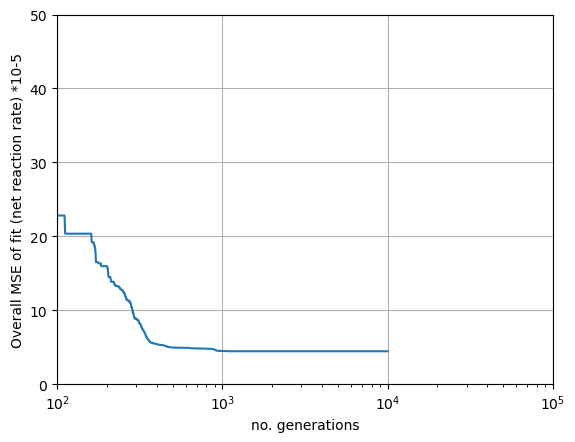

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

0.7164913525891018
8.215960202144545
8.2034513913349
0.800778400787856
8.76103576118301
8.757557037605695
8.767800543025539
2.218057339183962
8.271528034263545
8.241637695293814
8.33527404359847
8.210907136717818
0.9327722443256244
6.90480783877782
6.592889729091616
7.22668833814884
6.9518905938900675
2.1146427462748005
8.130578112559776
0.8686096075078287
7.869600383946685
7.8735732572239545
7.8922632497673675
6.885644265162581
1.559154632538384
7.569450192900099
3.461839946436826
6.477021404012216
8.466348225237263
8.471360787868743
0.3872201129156736
7.3977834797855095
-1.301029999999999
1.0560317591104718


In [34]:
res.X

array([ 0.71649135,  8.2159602 ,  8.20345139,  0.8007784 ,  8.76103576,
        8.75755704,  8.76780054,  2.21805734,  8.27152803,  8.2416377 ,
        8.33527404,  8.21090714,  0.93277224,  6.90480784,  6.59288973,
        7.22668834,  6.95189059,  2.11464275,  8.13057811,  0.86860961,
        7.86960038,  7.87357326,  7.89226325,  6.88564427,  1.55915463,
        7.56945019,  3.46183995,  6.4770214 ,  8.46634823,  8.47136079,
        0.38722011,  7.39778348, -1.30103   ,  1.05603176])

In [35]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

array([1. , 8.5, 8.5, 2. , 9. , 9. , 9. , 2. , 8. , 8. , 8. , 8. , 2. ,
       8. , 8. , 8. , 8. , 2. , 8. , 1. , 8. , 8. , 8. , 7. , 1. , 7. ,
       3. , 6. , 8. , 8. , 1. , 8. , 0.1])

In [36]:
for i in range(len (logkr)):
    print (logkr[i])

1.0
8.5
8.5
2.0
9.0
9.0
9.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
8.0
8.0
2.0
8.0
1.0
8.0
8.0
8.0
7.0
1.0
7.0
3.0
6.0
8.0
8.0
1.0
8.0
0.10000000000000002


In [37]:
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

1.0: 0.7164913525891018
8.5: 8.215960202144545
8.5: 8.2034513913349
2.0: 0.800778400787856
9.0: 8.76103576118301
9.0: 8.757557037605695
9.0: 8.767800543025539
2.0: 2.218057339183962
8.0: 8.271528034263545
8.0: 8.241637695293814
8.0: 8.33527404359847
8.0: 8.210907136717818
2.0: 0.9327722443256244
8.0: 6.90480783877782
8.0: 6.592889729091616
8.0: 7.22668833814884
8.0: 6.9518905938900675
2.0: 2.1146427462748005
8.0: 8.130578112559776
1.0: 0.8686096075078287
8.0: 7.869600383946685
8.0: 7.8735732572239545
8.0: 7.8922632497673675
7.0: 6.885644265162581
1.0: 1.559154632538384
7.0: 7.569450192900099
3.0: 3.461839946436826
6.0: 6.477021404012216
8.0: 8.466348225237263
8.0: 8.471360787868743
1.0: 0.3872201129156736
8.0: 7.3977834797855095
0.10000000000000002: 1.0560317591104718
coeff fit: 0.9628706003414494
r: 0.9812597007629782
